In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing
from tqdm import tqdm

import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import scipy.stats as stats
import numpyro
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()
matplotlib.rcParams.update({'font.size': 10})


In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/small-large/fcr.toml")

config = Config(toml_path=toml_path)

model = Baseline(config=config)

df = pd.read_csv(model.csv_path)

ind = df.pulse_amplitude.isin([0])
df = df[~ind].reset_index(drop=True).copy()

""" Process """
df, encoder_dict = model.load(df=df)


2023-08-21 14:21:06,741 - hbmep.config - INFO - Verifying configuration ...
2023-08-21 14:21:06,741 - hbmep.config - INFO - Success!
2023-08-21 14:21:06,756 - hbmep.model.baseline - INFO - Initialized model with baseline link
2023-08-21 14:21:06,802 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/C_SMA_LAR/fcr
2023-08-21 14:21:06,802 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/C_SMA_LAR/fcr
2023-08-21 14:21:06,803 - hbmep.dataset.core - INFO - Processing data ...
2023-08-21 14:21:06,808 - hbmep.utils.utils - INFO - func:load took: 0.01 sec


In [3]:
combinations = model._make_combinations(df=df, columns=model.combination_columns)   # sub x pos x size
combinations_inv = [
    (
        encoder_dict[model.subject].inverse_transform(np.array([c[0]]))[0],
        encoder_dict[model.features[0]].inverse_transform(np.array([c[1]]))[0],
        encoder_dict[model.features[1]].inverse_transform(np.array([c[2]]))[0]
    ) for c in combinations
]

conditions = model._make_combinations(df=df, columns=model.combination_columns[1:]) # pos x size
conditions_inv = [
    (
        encoder_dict[model.features[0]].inverse_transform(np.array([c[0]]))[0],
        encoder_dict[model.features[1]].inverse_transform(np.array([c[1]]))[0]
    ) for c in conditions
]
conditions_inv_joined = ["::".join(c) for c in conditions_inv]

## Efficay

### Process

In [4]:
muscles = ["deltoid", "biceps", "triceps", "ecr", "fcr", "adm"]
a = None

for muscle in muscles:
    a_muscle = None

    for i, c in enumerate(combinations):
        c_inv = combinations_inv[i]
        src = f"/home/vishu/repos/hbmep-paper/reports/C_SMA_LAR/{muscle}/iterative/{c_inv[0]}/{c_inv[1]}/{c_inv[2]}"

        mcmc = az.from_netcdf(os.path.join(src, "mcmc.nc"))["posterior"]
        a_temp = mcmc[site.a].to_numpy()
        a_temp = a_temp[..., 0, 0, 0, 0]
        a_temp = a_temp[..., None]

        if a_muscle is None:
            a_muscle = a_temp
        else:
            a_muscle = np.concatenate((a_muscle, a_temp), axis=-1)

    a_muscle = a_muscle[..., None]

    if a is None:
        a = a_muscle
    else:
        a = np.concatenate((a, a_muscle), axis=-1)


In [5]:
a.shape

(4, 6000, 403, 6)

In [6]:
t = az.summary({"a": a})
t.shape

(2418, 9)

In [7]:
(t.r_hat > 1.05).sum()

42

In [8]:
t.r_hat.max()

1.53

In [9]:
a = a.reshape(-1, *a.shape[2:])
a = np.array(jax.random.permutation(model.rng_key, x=a, axis=0, independent=True))
a_map = a.mean(axis=0)

a.shape

(24000, 403, 6)

In [10]:
a_map.shape

(403, 6)

In [11]:
def _process(keep_conditions: list, keep_muscles: list[str], threshold: int):
    keep_muscles_ind = [i for i, muscle in enumerate(muscles) if muscle in keep_muscles]

    pr = []
    effect_size = []
    t_test = []
    rank_test = []
    heat_map = []
    mask = []

    for i, (i_pos, i_size) in enumerate(keep_conditions):
        curr_pr = []
        curr_effect_size = []
        curr_t_test = []
        curr_rank_test = []
        curr_heat_map = []
        curr_mask = []

        for j, (j_pos, j_size) in enumerate(keep_conditions):
            if i == j:
                curr_pr.append(0)
                curr_effect_size.append((0, 0))
                curr_t_test.append(1)
                curr_rank_test.append(1)
                curr_heat_map.append(f"D")
                curr_mask.append(False)
                continue

            i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos and c[2] == i_size]
            j_com = [(j, c) for j, c in enumerate(combinations) if c[1] == j_pos and c[2] == j_size]

            i_com = sorted(i_com, key=lambda x: x[1][0])
            j_com = sorted(j_com, key=lambda x: x[1][0])

            i_sub = set([v[1][0] for v in i_com])
            j_sub = set([v[1][0] for v in j_com])
            common_sub = i_sub.intersection(j_sub)

            i_ind = [v[0] for v in i_com if v[1][0] in common_sub]
            j_ind = [v[0] for v in j_com if v[1][0] in common_sub]

            N = len(common_sub) * len(keep_muscles_ind)

            if not len(common_sub) or len(common_sub) < threshold:
                curr_pr.append(0)
                curr_effect_size.append((0, 0))
                curr_t_test.append(1)
                curr_rank_test.append(1)
                curr_heat_map.append(f"NA:0")
                curr_mask.append(False)
                continue

            curr_mask.append(True)

            ## Distributions
            i_a = a[:, i_ind, ...]
            i_a = i_a[..., keep_muscles_ind]
            i_a = i_a.reshape(i_a.shape[0], -1)

            j_a = a[:, j_ind, ...]
            j_a = j_a[..., keep_muscles_ind]
            j_a = j_a.reshape(j_a.shape[0], -1)

            diff_a = i_a - j_a
            diff_a_mu = diff_a.mean(axis=-1)
            pr_a_mu = (diff_a_mu < 0).mean()
            curr_pr.append(pr_a_mu)

            ## Effect-size
            i_mu_a_estimate = i_a.mean(axis=-1)
            i_sigma_sq_a_estimate = np.power(i_a - i_mu_a_estimate[:, None], 2).sum(axis=-1) / (N - 1)

            j_mu_a_estimate = j_a.mean(axis=-1)
            j_sigma_sq_a_estimate = np.power(j_a - j_mu_a_estimate[:, None], 2).sum(axis=-1) / (N - 1)

            i_j_effect_size = (i_mu_a_estimate - j_mu_a_estimate) / np.power( (i_sigma_sq_a_estimate + j_sigma_sq_a_estimate) / 2, 0.5)
            hpdi_interval_lo, hpdi_interval_hi = hpdi(i_j_effect_size, prob=.95)
            curr_effect_size.append((hpdi_interval_lo, hpdi_interval_hi))

            curr_heat_map.append(f"{pr_a_mu:.2f}:{len(common_sub)}\n({hpdi_interval_lo:.2f}, {hpdi_interval_hi:.2f})")

            ## MAP
            i_map = a_map[i_ind, ...]
            i_map = i_map[..., keep_muscles_ind]
            i_map = i_map.reshape(-1,)

            j_map = a_map[j_ind, ...]
            j_map = j_map[..., keep_muscles_ind]
            j_map = j_map.reshape(-1,)

            diff_map = i_map - j_map
            t_test_map = stats.ttest_1samp(a=diff_map, popmean=0, alternative="less")
            rank_test_map = stats.wilcoxon(x=diff_map, alternative="less")

            curr_t_test.append(t_test_map.pvalue)
            curr_rank_test.append(rank_test_map.pvalue)

        pr.append(curr_pr)
        effect_size.append(curr_effect_size)
        t_test.append(curr_t_test)
        rank_test.append(curr_rank_test)
        heat_map.append(curr_heat_map)
        mask.append(curr_mask)

    pr = np.array(pr)
    effect_size = np.array(effect_size)
    t_test = np.array(t_test)
    rank_test = np.array(rank_test)
    heat_map = np.array(heat_map)
    mask = np.array(mask)

    return pr, effect_size, t_test, rank_test, heat_map, mask

In [12]:
efficacy_score = {
    "non_ground_small_lateral": {},
    "non_ground_big_lateral": {},
    "non_ground_small_vs_big": {},
    "ground_small_lateral": {},
    "ground_big_lateral": {},
    "ground_small_vs_big": {}
}


### Non-ground contacts

#### Q. How far lateral? - Small

In [13]:
keep_conditions_inv = [c for c in conditions_inv if c[1] == "S" and c[0].split("-")[0] != "" and c[0].split("-")[0][:2] == c[0].split("-")[1][:2] and c[0].split("-")[0][2:] == "M" and c[0].split("-")[1][2:] in {"LL", "L", "LM1", "LM2"}]

keep_conditions_inv

[('C5M-C5L', 'S'),
 ('C5M-C5LL', 'S'),
 ('C5M-C5LM1', 'S'),
 ('C5M-C5LM2', 'S'),
 ('C6M-C6L', 'S'),
 ('C6M-C6LL', 'S'),
 ('C6M-C6LM1', 'S'),
 ('C6M-C6LM2', 'S')]

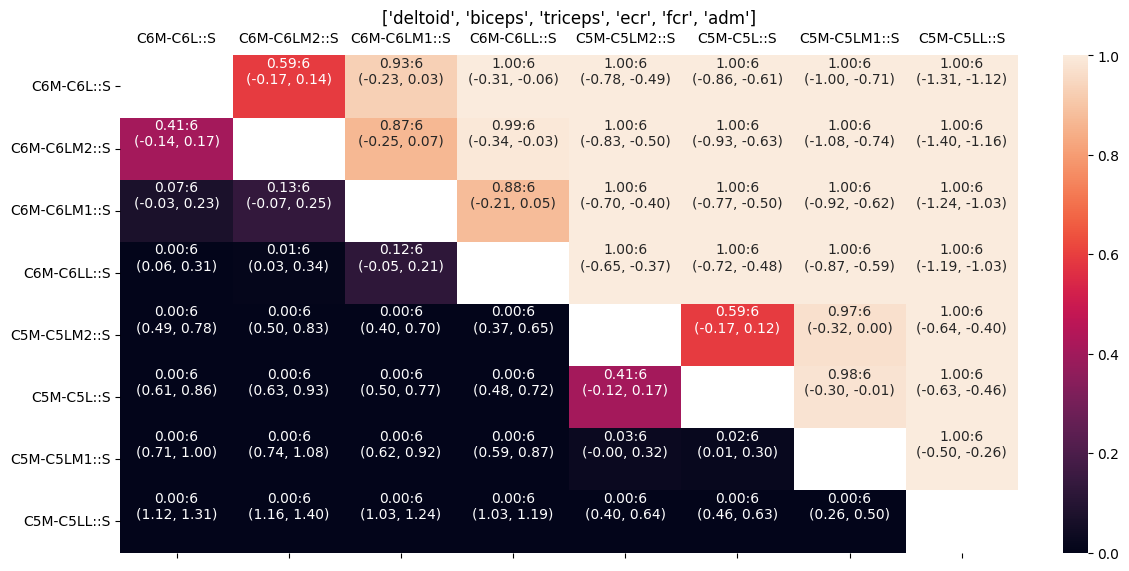

In [14]:
keep_conditions = [
    (
        encoder_dict[model.features[0]].transform(np.array([c_inv[0]]))[0],
        encoder_dict[model.features[1]].transform(np.array([c_inv[1]]))[0]
    ) for c_inv in keep_conditions_inv
]
n_keep_conditions = len(keep_conditions)
keep_conditions_inv_joined = ["::".join(row) for row in keep_conditions_inv]
keep_muscles = muscles

pr, effect_size, t_test, rank_test, heat_map, mask = _process(keep_conditions=keep_conditions, keep_muscles=keep_muscles, threshold=1)

plt.figure(figsize=(1.4 * n_keep_conditions, .7 * n_keep_conditions), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_conditions_inv_joined)[ind],
    yticklabels=np.array(keep_conditions_inv_joined)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title(f"{keep_muscles}");

In [15]:
for i, c_inv in enumerate(np.array(keep_conditions_inv_joined)[ind].tolist()):
    efficacy_score["non_ground_small_lateral"][c_inv] = [n_keep_conditions - i]

for i, (i_pos, i_size) in enumerate(keep_conditions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos and c[2] == i_size]
    # can further filter i_com to include only applicable combinations
    i_ind = [v[0] for v in i_com]
    i_a = a[:, i_ind, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)
    c_inv_joined = keep_conditions_inv_joined[i]
    efficacy_score["non_ground_small_lateral"][c_inv_joined].append(i_a.mean())

In [16]:
efficacy_score["non_ground_small_lateral"]

{'C6M-C6L::S': [8, 150.4131023609686],
 'C6M-C6LM2::S': [7, 152.72150876024878],
 'C6M-C6LM1::S': [6, 164.263842269927],
 'C6M-C6LL::S': [5, 174.5925200560202],
 'C5M-C5LM2::S': [4, 255.65923407811877],
 'C5M-C5L::S': [3, 258.7922221672641],
 'C5M-C5LM1::S': [2, 283.81870010108486],
 'C5M-C5LL::S': [1, 354.2028387866565]}

#### Q. How far lateral? - Big

In [17]:
keep_conditions_inv = [c for c in conditions_inv if c[1] == "B" and c[0].split("-")[0] != "" and c[0].split("-")[0][:2] == c[0].split("-")[1][:2] and c[0].split("-")[0][2:] == "M" and c[0].split("-")[1][2:] in {"LL", "L", "LM"}]

keep_conditions_inv

[('C5M-C5L', 'B'),
 ('C5M-C5LL', 'B'),
 ('C5M-C5LM', 'B'),
 ('C6M-C6L', 'B'),
 ('C6M-C6LL', 'B'),
 ('C6M-C6LM', 'B')]

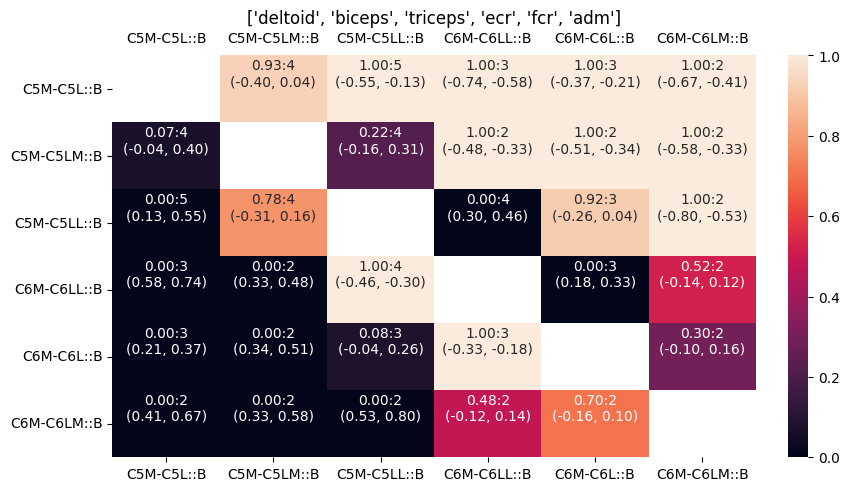

In [18]:
keep_conditions = [
    (
        encoder_dict[model.features[0]].transform(np.array([c_inv[0]]))[0],
        encoder_dict[model.features[1]].transform(np.array([c_inv[1]]))[0]
    ) for c_inv in keep_conditions_inv
]
n_keep_conditions = len(keep_conditions)
keep_conditions_inv_joined = ["::".join(row) for row in keep_conditions_inv]
keep_muscles = muscles

pr, effect_size, t_test, rank_test, heat_map, mask = _process(keep_conditions=keep_conditions, keep_muscles=keep_muscles, threshold=1)

plt.figure(figsize=(1.4 * n_keep_conditions, .8 * n_keep_conditions), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_conditions_inv_joined)[ind],
    yticklabels=np.array(keep_conditions_inv_joined)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title(f"{keep_muscles}");

In [19]:
for i, c_inv in enumerate(np.array(keep_conditions_inv_joined)[ind].tolist()):
    efficacy_score["non_ground_big_lateral"][c_inv] = [n_keep_conditions - i]

for i, (i_pos, i_size) in enumerate(keep_conditions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos and c[2] == i_size]
    # can further filter i_com to include only applicable combinations
    i_ind = [v[0] for v in i_com]
    i_a = a[:, i_ind, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)
    c_inv_joined = keep_conditions_inv_joined[i]
    efficacy_score["non_ground_big_lateral"][c_inv_joined].append(i_a.mean())

In [20]:
efficacy_score["non_ground_big_lateral"]

{'C5M-C5L::B': [6, 74.65695232635055],
 'C5M-C5LM::B': [5, 92.57184259025452],
 'C5M-C5LL::B': [4, 141.3208236721542],
 'C6M-C6LL::B': [3, 112.17028038498367],
 'C6M-C6L::B': [2, 89.25608760385605],
 'C6M-C6LM::B': [1, 111.27954594371505]}

#### Q. Small vs Big?

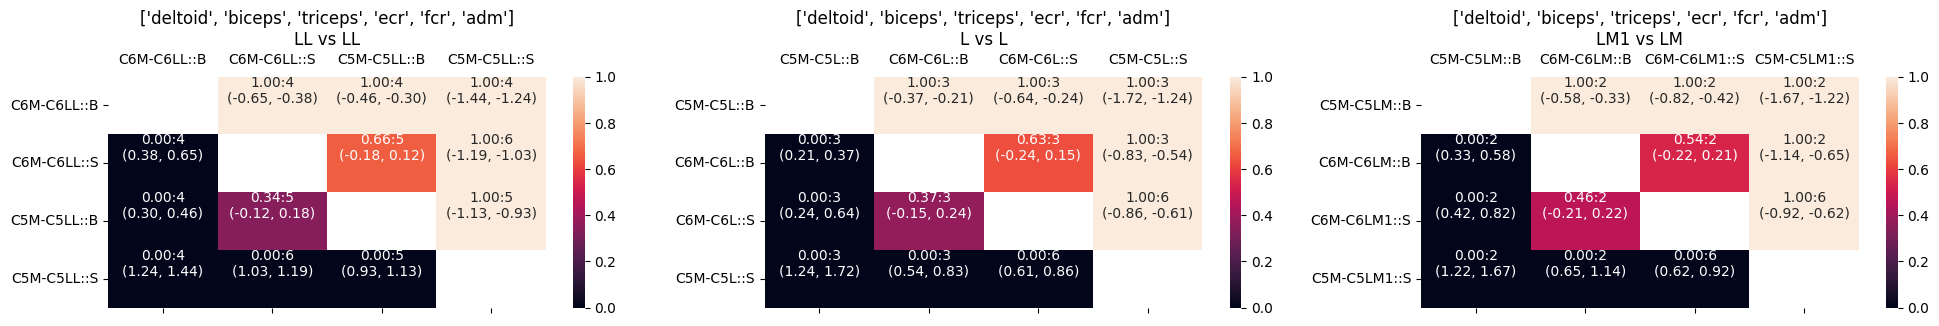

In [21]:
small_big_lateral_pattern = [
    ("LL", "LL"), ("L", "L"), ("LM1", "LM")
]

nrows, ncols = 1, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 3 * nrows))

for i, (small_laterality, big_laterality) in enumerate(small_big_lateral_pattern):
    ax = axes[i % ncols]

    keep_conditions_inv = [c for c in conditions_inv if c[1] == "S" and c[0].split("-")[0] != "" and c[0].split("-")[0][:2] == c[0].split("-")[1][:2] and c[0].split("-")[0][2:] == "M" and c[0].split("-")[1][2:] in [small_laterality]]
    keep_conditions_inv += [c for c in conditions_inv if c[1] == "B" and c[0].split("-")[0] != "" and c[0].split("-")[0][:2] == c[0].split("-")[1][:2] and c[0].split("-")[0][2:] == "M" and c[0].split("-")[1][2:] in [big_laterality]]

    keep_conditions = [
        (
            encoder_dict[model.features[0]].transform(np.array([c_inv[0]]))[0],
            encoder_dict[model.features[1]].transform(np.array([c_inv[1]]))[0]
        ) for c_inv in keep_conditions_inv
    ]
    n_keep_conditions = len(keep_conditions)
    keep_conditions_inv_joined = ["::".join(row) for row in keep_conditions_inv]
    keep_muscles = muscles

    pr, effect_size, t_test, rank_test, heat_map, mask = _process(keep_conditions=keep_conditions, keep_muscles=keep_muscles, threshold=1)

    ind = list(zip(
        range(pr.shape[0]),
        (pr > .95).sum(axis=1) / mask.sum(axis=1),
        pr.sum(axis=1).tolist() / mask.sum(axis=1)
    ))

    ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
    ind = [v[0] for v in ind]

    sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind], ax=ax)
    sns.heatmap(
        pr[ind, :][:, ind],
        annot=heat_map[ind, :][:, ind],
        annot_kws={'va':'bottom'},
        fmt="",
        cbar=False,
        xticklabels=np.array(keep_conditions_inv_joined)[ind],
        yticklabels=np.array(keep_conditions_inv_joined)[ind],
        mask=~mask[ind, :][:, ind],
        ax=ax
    )

    ax.tick_params(labeltop=True, labelbottom=False)
    ax.set_xticklabels(np.array(keep_conditions_inv_joined)[ind], rotation=0)
    ax.set_yticklabels(np.array(keep_conditions_inv_joined)[ind], rotation=0)
    ax.set_title(f"{keep_muscles}\n{small_laterality} vs {big_laterality}");

    efficacy_score["non_ground_small_vs_big"][f"{small_laterality}_{big_laterality}"] = {}

    for i, c_inv in enumerate(np.array(keep_conditions_inv_joined)[ind].tolist()):
        efficacy_score["non_ground_small_vs_big"][f"{small_laterality}_{big_laterality}"][c_inv] = [n_keep_conditions - i]

    for i, (i_pos, i_size) in enumerate(keep_conditions):
        i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos and c[2] == i_size]
        # can further filter i_com to include only applicable combinations
        i_ind = [v[0] for v in i_com]
        i_a = a[:, i_ind, ...]
        i_a = i_a.reshape(i_a.shape[0], -1)
        c_inv_joined = keep_conditions_inv_joined[i]
        efficacy_score["non_ground_small_vs_big"][f"{small_laterality}_{big_laterality}"][c_inv_joined].append(i_a.mean())


In [22]:
efficacy_score["non_ground_small_vs_big"].keys()

dict_keys(['LL_LL', 'L_L', 'LM1_LM'])

In [23]:
efficacy_score["non_ground_small_vs_big"]["LL_LL"]

{'C6M-C6LL::B': [4, 112.17028038498367],
 'C6M-C6LL::S': [3, 174.5925200560202],
 'C5M-C5LL::B': [2, 141.3208236721542],
 'C5M-C5LL::S': [1, 354.2028387866565]}

In [24]:
efficacy_score["non_ground_small_vs_big"]["L_L"]

{'C5M-C5L::B': [4, 74.65695232635055],
 'C6M-C6L::B': [3, 89.25608760385605],
 'C6M-C6L::S': [2, 150.4131023609686],
 'C5M-C5L::S': [1, 258.7922221672641]}

In [25]:
efficacy_score["non_ground_small_vs_big"]["LM1_LM"]


{'C5M-C5LM::B': [4, 92.57184259025452],
 'C6M-C6LM::B': [3, 111.27954594371505],
 'C6M-C6LM1::S': [2, 164.263842269927],
 'C5M-C5LM1::S': [1, 283.81870010108486]}

### Ground

#### Q. How far lateral? - Small

In [26]:
keep_conditions_inv = [c for c in conditions_inv if c[1] == "S" and c[0].split("-")[0] == ""]
keep_conditions_inv

[('-C5L', 'S'),
 ('-C5LL', 'S'),
 ('-C5LM1', 'S'),
 ('-C5LM2', 'S'),
 ('-C5M', 'S'),
 ('-C6L', 'S'),
 ('-C6LL', 'S'),
 ('-C6LM1', 'S'),
 ('-C6LM2', 'S'),
 ('-C6M', 'S')]

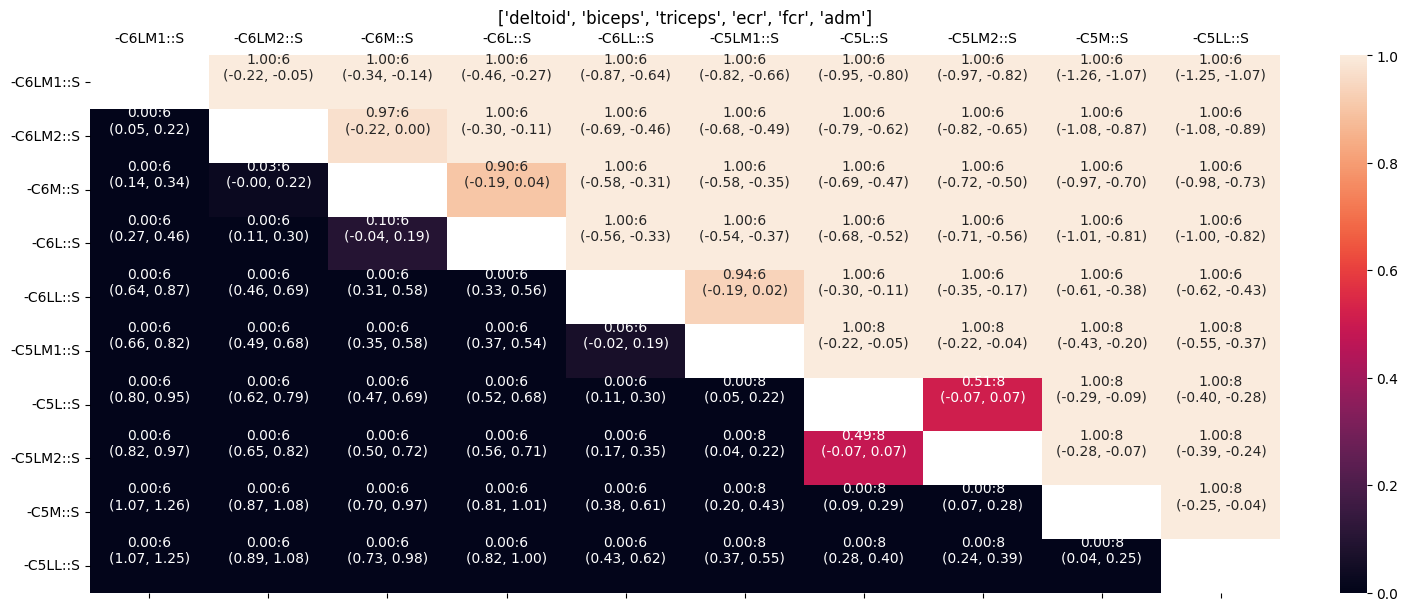

In [27]:
keep_conditions = [
    (
        encoder_dict[model.features[0]].transform(np.array([c_inv[0]]))[0],
        encoder_dict[model.features[1]].transform(np.array([c_inv[1]]))[0]
    ) for c_inv in keep_conditions_inv
]
n_keep_conditions = len(keep_conditions)
keep_conditions_inv_joined = ["::".join(row) for row in keep_conditions_inv]
keep_muscles = muscles

pr, effect_size, t_test, rank_test, heat_map, mask = _process(keep_conditions=keep_conditions, keep_muscles=keep_muscles, threshold=1)

plt.figure(figsize=(1.4 * n_keep_conditions, .6 * n_keep_conditions), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_conditions_inv_joined)[ind],
    yticklabels=np.array(keep_conditions_inv_joined)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title(f"{keep_muscles}");

In [28]:
for i, c_inv in enumerate(np.array(keep_conditions_inv_joined)[ind].tolist()):
    efficacy_score["ground_small_lateral"][c_inv] = [n_keep_conditions - i]

for i, (i_pos, i_size) in enumerate(keep_conditions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos and c[2] == i_size]
    # can further filter i_com to include only applicable combinations
    i_ind = [v[0] for v in i_com]
    i_a = a[:, i_ind, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)
    c_inv_joined = keep_conditions_inv_joined[i]
    efficacy_score["ground_small_lateral"][c_inv_joined].append(i_a.mean())

In [29]:
efficacy_score["ground_small_lateral"]

{'-C6LM1::S': [10, 147.37476357872757],
 '-C6LM2::S': [9, 164.54288632589248],
 '-C6M::S': [8, 178.84124201242503],
 '-C6L::S': [7, 188.58083996351715],
 '-C6LL::S': [6, 232.6188951193034],
 '-C5LM1::S': [5, 205.45866009463882],
 '-C5L::S': [4, 223.36035415710734],
 '-C5LM2::S': [3, 223.41981456863854],
 '-C5M::S': [2, 247.3916981461428],
 '-C5LL::S': [1, 265.4981342607496]}

#### Q. How far lateral? - Big

In [30]:
lateral_pattern = ["LL", "L", "LM", "M"]
keep_conditions_inv = [c for c in conditions_inv if c[1] == "B" and c[0].split("-")[0] == "" and c[0].split("-")[1][2:] in lateral_pattern]
keep_conditions_inv

[('-C5L', 'B'),
 ('-C5LL', 'B'),
 ('-C5LM', 'B'),
 ('-C5M', 'B'),
 ('-C6L', 'B'),
 ('-C6LL', 'B'),
 ('-C6LM', 'B'),
 ('-C6M', 'B'),
 ('-C7LM', 'B'),
 ('-C7M', 'B')]

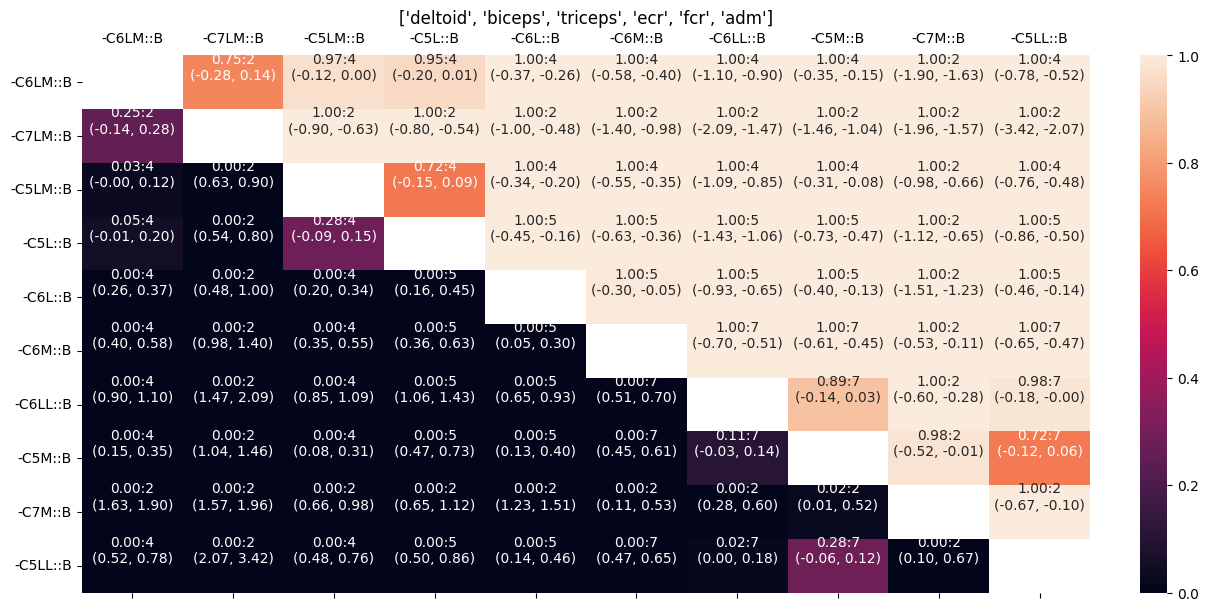

In [31]:
keep_conditions = [
    (
        encoder_dict[model.features[0]].transform(np.array([c_inv[0]]))[0],
        encoder_dict[model.features[1]].transform(np.array([c_inv[1]]))[0]
    ) for c_inv in keep_conditions_inv
]
n_keep_conditions = len(keep_conditions)
keep_conditions_inv_joined = ["::".join(row) for row in keep_conditions_inv]
keep_muscles = muscles

pr, effect_size, t_test, rank_test, heat_map, mask = _process(keep_conditions=keep_conditions, keep_muscles=keep_muscles, threshold=1)

plt.figure(figsize=(1.2 * n_keep_conditions, .6 * n_keep_conditions), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_conditions_inv_joined)[ind],
    yticklabels=np.array(keep_conditions_inv_joined)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title(f"{keep_muscles}");

In [32]:
for i, c_inv in enumerate(np.array(keep_conditions_inv_joined)[ind].tolist()):
    efficacy_score["ground_big_lateral"][c_inv] = [n_keep_conditions - i]

for i, (i_pos, i_size) in enumerate(keep_conditions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos and c[2] == i_size]
    # can further filter i_com to include only applicable combinations
    i_ind = [v[0] for v in i_com]
    i_a = a[:, i_ind, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)
    c_inv_joined = keep_conditions_inv_joined[i]
    efficacy_score["ground_big_lateral"][c_inv_joined].append(i_a.mean())

In [33]:
efficacy_score["ground_big_lateral"]

{'-C6LM::B': [10, 86.9027406414636],
 '-C7LM::B': [9, 65.85908717234207],
 '-C5LM::B': [8, 92.23579792461285],
 '-C5L::B': [7, 86.25519394768845],
 '-C6L::B': [6, 112.79266668374949],
 '-C6M::B': [5, 160.98521960748542],
 '-C6LL::B': [4, 191.14558718783664],
 '-C5M::B': [3, 197.67315052773742],
 '-C7M::B': [2, 185.70603808973547],
 '-C5LL::B': [1, 201.4612032394557]}

#### Q. Small vs Big?

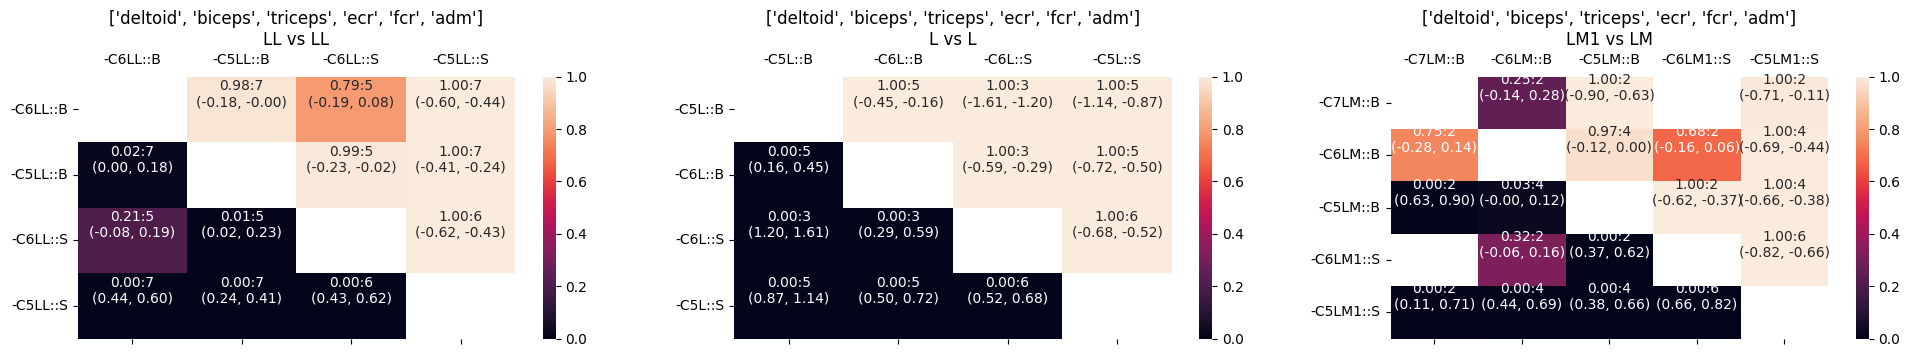

In [34]:
small_big_lateral_pattern = [
    ("LL", "LL"), ("L", "L"), ("LM1", "LM")
]

nrows, ncols = 1, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 3.4 * nrows))

for i, (small_laterality, big_laterality) in enumerate(small_big_lateral_pattern):
    ax = axes[i % ncols]

    keep_conditions_inv = [c for c in conditions_inv if c[1] == "S" and c[0].split("-")[0] == "" and c[0].split("-")[1][2:] in [small_laterality]]
    keep_conditions_inv += [c for c in conditions_inv if c[1] == "B" and c[0].split("-")[0] == "" and c[0].split("-")[1][2:] in [big_laterality]]

    keep_conditions = [
        (
            encoder_dict[model.features[0]].transform(np.array([c_inv[0]]))[0],
            encoder_dict[model.features[1]].transform(np.array([c_inv[1]]))[0]
        ) for c_inv in keep_conditions_inv
    ]
    n_keep_conditions = len(keep_conditions)
    keep_conditions_inv_joined = ["::".join(row) for row in keep_conditions_inv]
    keep_muscles = muscles

    pr, effect_size, t_test, rank_test, heat_map, mask = _process(keep_conditions=keep_conditions, keep_muscles=keep_muscles, threshold=1)

    ind = list(zip(
        range(pr.shape[0]),
        (pr > .95).sum(axis=1) / mask.sum(axis=1),
        pr.sum(axis=1).tolist() / mask.sum(axis=1)
    ))

    ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
    ind = [v[0] for v in ind]

    sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind], ax=ax)
    sns.heatmap(
        pr[ind, :][:, ind],
        annot=heat_map[ind, :][:, ind],
        annot_kws={'va':'bottom'},
        fmt="",
        cbar=False,
        xticklabels=np.array(keep_conditions_inv_joined)[ind],
        yticklabels=np.array(keep_conditions_inv_joined)[ind],
        mask=~mask[ind, :][:, ind],
        ax=ax
    )

    ax.tick_params(labeltop=True, labelbottom=False)
    ax.set_xticklabels(np.array(keep_conditions_inv_joined)[ind], rotation=0)
    ax.set_yticklabels(np.array(keep_conditions_inv_joined)[ind], rotation=0)
    ax.set_title(f"{keep_muscles}\n{small_laterality} vs {big_laterality}");

    efficacy_score["ground_small_vs_big"][f"{small_laterality}_{big_laterality}"] = {}

    for i, c_inv in enumerate(np.array(keep_conditions_inv_joined)[ind].tolist()):
        efficacy_score["ground_small_vs_big"][f"{small_laterality}_{big_laterality}"][c_inv] = [n_keep_conditions - i]

    for i, (i_pos, i_size) in enumerate(keep_conditions):
        i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos and c[2] == i_size]
        # can further filter i_com to include only applicable combinations
        i_ind = [v[0] for v in i_com]
        i_a = a[:, i_ind, ...]
        i_a = i_a.reshape(i_a.shape[0], -1)
        c_inv_joined = keep_conditions_inv_joined[i]
        efficacy_score["ground_small_vs_big"][f"{small_laterality}_{big_laterality}"][c_inv_joined].append(i_a.mean())

In [35]:
efficacy_score["ground_small_vs_big"].keys()

dict_keys(['LL_LL', 'L_L', 'LM1_LM'])

In [36]:
efficacy_score["ground_small_vs_big"]["LL_LL"]

{'-C6LL::B': [4, 191.14558718783664],
 '-C5LL::B': [3, 201.4612032394557],
 '-C6LL::S': [2, 232.6188951193034],
 '-C5LL::S': [1, 265.4981342607496]}

In [37]:
efficacy_score["ground_small_vs_big"]["L_L"]

{'-C5L::B': [4, 86.25519394768845],
 '-C6L::B': [3, 112.79266668374949],
 '-C6L::S': [2, 188.58083996351715],
 '-C5L::S': [1, 223.36035415710734]}

In [38]:
efficacy_score["ground_small_vs_big"]["LM1_LM"]


{'-C7LM::B': [5, 65.85908717234207],
 '-C6LM::B': [4, 86.9027406414636],
 '-C5LM::B': [3, 92.23579792461285],
 '-C6LM1::S': [2, 147.37476357872757],
 '-C5LM1::S': [1, 205.45866009463882]}

## Selectivity

### Process

In [39]:
muscles_map = {
    "adm": "auc_1",
    "biceps": "auc_2",
    "deltoid": "auc_4",
    "ecr": "auc_5",
    "fcr": "auc_6",
    "triceps": "auc_7"
}

n_muscles = len(muscles)


In [40]:
a = None
b = None
L = None
H = None
v = None

for muscle in muscles:
    a_muscle = None
    b_muscle = None
    L_muscle = None
    H_muscle = None
    v_muscle = None

    for i, c in enumerate(combinations):
        c_inv = combinations_inv[i]
        src = f"/home/vishu/repos/hbmep-paper/reports/C_SMA_LAR/{muscle}/iterative/{c_inv[0]}/{c_inv[1]}/{c_inv[2]}"
        mcmc = az.from_netcdf(os.path.join(src, "mcmc.nc"))["posterior"]

        a_temp = mcmc[site.a].to_numpy()
        a_temp = a_temp[..., 0, 0, 0, 0]
        a_temp = a_temp[..., None]

        b_temp = mcmc[site.b].to_numpy()
        b_temp = b_temp[..., 0, 0, 0, 0]
        b_temp = b_temp[..., None]

        L_temp = mcmc[site.L].to_numpy()
        L_temp = L_temp[..., 0, 0, 0, 0]
        L_temp = L_temp[..., None]

        H_temp = mcmc[site.H].to_numpy()
        H_temp = H_temp[..., 0, 0, 0, 0]
        H_temp = H_temp[..., None]

        v_temp = mcmc[site.v].to_numpy()
        v_temp = v_temp[..., 0, 0, 0, 0]
        v_temp = v_temp[..., None]

        if a_muscle is None:
            a_muscle = a_temp
            b_muscle = b_temp
            L_muscle = L_temp
            H_muscle = H_temp
            v_muscle = v_temp
        else:
            a_muscle = np.concatenate((a_muscle, a_temp), axis=-1)
            b_muscle = np.concatenate((b_muscle, b_temp), axis=-1)
            L_muscle = np.concatenate((L_muscle, L_temp), axis=-1)
            H_muscle = np.concatenate((H_muscle, H_temp), axis=-1)
            v_muscle = np.concatenate((v_muscle, v_temp), axis=-1)

    a_muscle = a_muscle[..., None]
    b_muscle = b_muscle[..., None]
    L_muscle = L_muscle[..., None]
    H_muscle = H_muscle[..., None]
    v_muscle = v_muscle[..., None]

    if a is None:
        a = a_muscle
        b = b_muscle
        L = L_muscle
        H = H_muscle
        v = v_muscle
    else:
        a = np.concatenate((a, a_muscle), axis=-1)
        b = np.concatenate((b, b_muscle), axis=-1)
        L = np.concatenate((L, L_muscle), axis=-1)
        H = np.concatenate((H, H_muscle), axis=-1)
        v = np.concatenate((v, v_muscle), axis=-1)

In [41]:
a.shape

(4, 6000, 403, 6)

In [42]:
a = a.reshape(-1, *a.shape[2:])
b = b.reshape(-1, *b.shape[2:])
L = L.reshape(-1, *L.shape[2:])
H = H.reshape(-1, *H.shape[2:])
v = v.reshape(-1, *v.shape[2:])

In [43]:
a.shape

(24000, 403, 6)

In [44]:
ind = jax.random.permutation(model.rng_key, np.array(range(a.shape[0])))

N_DOWN = 9000
a_down = a[ind, ...][:N_DOWN, ...]
b_down = b[ind, ...][:N_DOWN, ...]
L_down = L[ind, ...][:N_DOWN, ...]
H_down = H[ind, ...][:N_DOWN, ...]
v_down = v[ind, ...][:N_DOWN, ...]

a = a_down
b = b_down
L = L_down
H = H_down
v = v_down


In [45]:
x = None

for muscle in muscles:
    x_muscle = None

    for i, c in enumerate(combinations):
        ind = df[model.combination_columns].apply(tuple, axis=1).isin([c])
        temp_df = df[ind].reset_index(drop=True).copy()

        lo, hi = temp_df[model.intensity].min(), temp_df[model.intensity].max()
        x_temp = np.linspace(lo, hi, 100)
        x_temp = x_temp[..., None]

        if x_muscle is None:
            x_muscle = x_temp
        else:
            x_muscle = np.concatenate((x_muscle, x_temp), axis=-1)

    x_muscle = x_muscle[..., None]

    if x is None:
        x = x_muscle
    else:
        x = np.concatenate((x, x_muscle), axis=-1)

x = x[:, None, ...]

In [46]:
x.shape

(100, 1, 403, 6)

In [47]:
assert np.unique(x.min(axis=(0, 1)), axis=1).shape[1] == 1

In [48]:
assert np.unique(x.max(axis=(0, 1)), axis=1).shape[1] == 1

In [49]:
a.shape

(9000, 403, 6)

In [50]:
x.shape

(100, 1, 403, 6)

In [51]:
y = L + jnp.maximum(
    0,
    -1
    + (H + 1)
    / jnp.power(
        1
        + (jnp.power(1 + H, v) - 1)
        * jnp.exp(-b * (x - a)),
        1 / v
    )
)

y.shape

(100, 9000, 403, 6)

In [52]:
y_map = y.mean(axis=1)
y_map.shape

(100, 403, 6)

In [53]:
y_max = None

for i, (sub, pos, size) in enumerate(combinations):
    com = [(j, c) for j, c in enumerate(combinations) if c[0] == sub]
    ind = [v[0] for v in com]
    y_max_temp = y_map[:, ind, ...].max(axis=(0, 1))
    y_max_temp = y_max_temp[None, ...]

    if y_max is None:
        y_max = y_max_temp
    else:
        y_max = np.concatenate((y_max, y_max_temp), axis=0)

y_max = y_max[None, None , ...]

y_max.shape


(1, 1, 403, 6)

In [54]:
y.shape

(100, 9000, 403, 6)

In [55]:
y = y / y_max

y.shape

(100, 9000, 403, 6)

In [56]:
y_ratio = y / y.sum(axis=-1)[..., None]

y_ratio.shape

(100, 9000, 403, 6)

In [57]:
entropy_adj = 1 + (
    (y_ratio * jnp.log(y_ratio)).sum(axis=-1)
    / jnp.log(n_muscles)
)

entropy_adj.shape

(100, 9000, 403)

In [58]:
entropy_adj = np.array(jax.random.permutation(model.rng_key, x=entropy_adj, axis=1, independent=True))
entropy_adj.shape

(100, 9000, 403)

In [59]:
entropy_adj_map = entropy_adj.mean(axis=1)
entropy_adj_map.shape

(100, 403)

In [60]:
entropy_adj_hpdi = hpdi(entropy_adj, axis=1)
entropy_adj_hpdi.shape

(100, 2, 403)

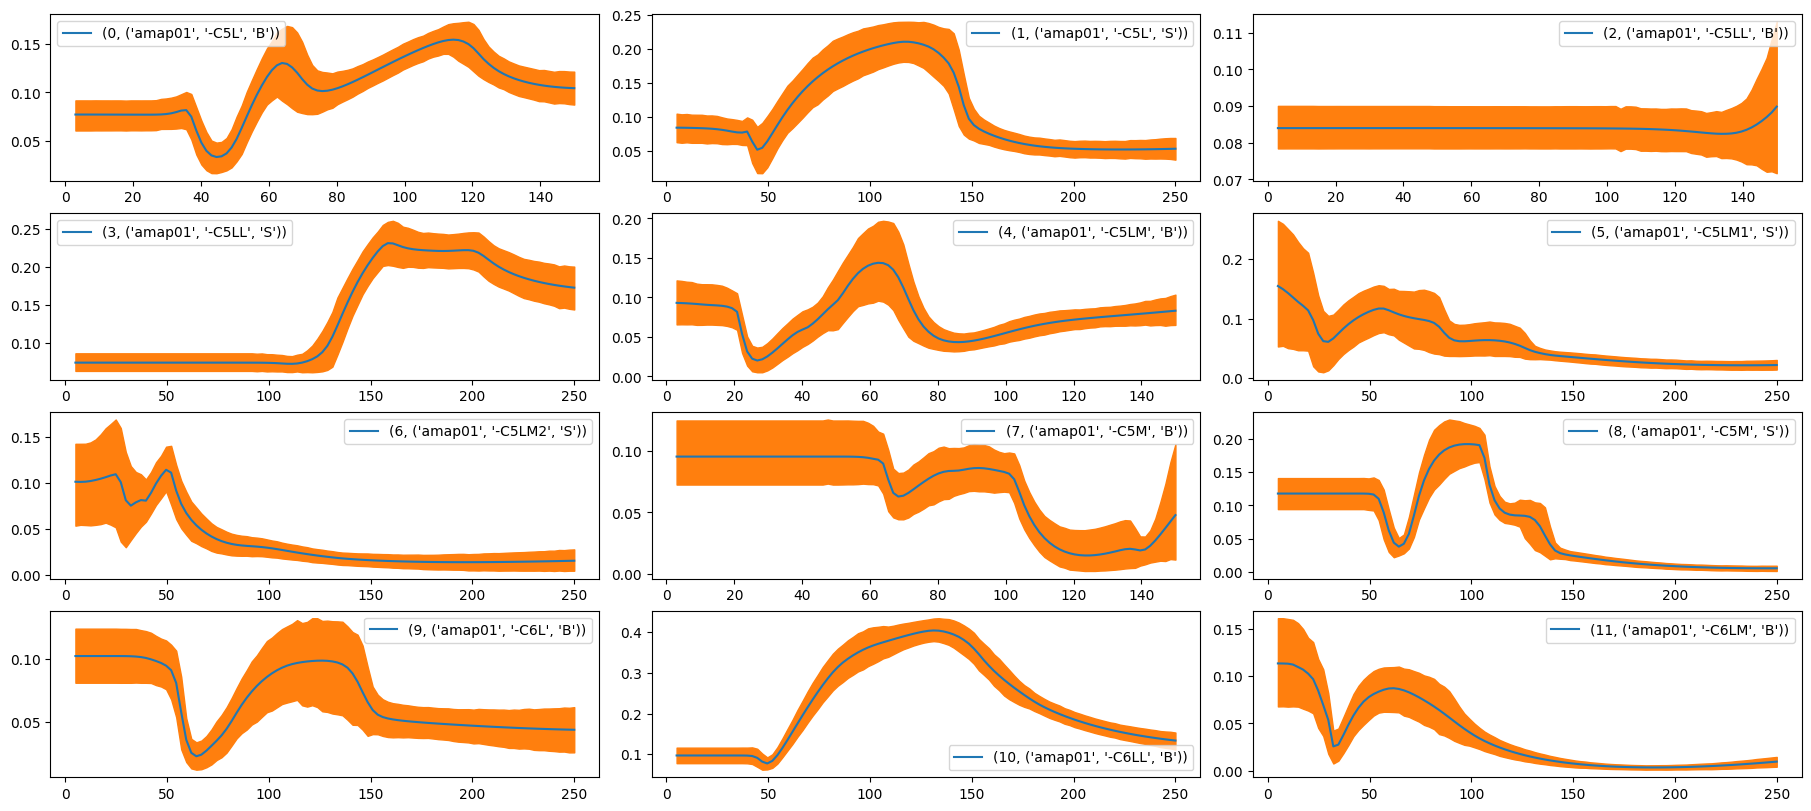

In [61]:
nrows = 4
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 2 * nrows), constrained_layout=True)

for i in range(12):
    ax = axes[i // ncols, i % ncols]
    sns.lineplot(x=x[:, 0, i, 0], y=entropy_adj_map[:, i], label=f"{i, combinations_inv[i]}", ax=ax)
    ax.fill_between(
    x[:, 0, i, 0],
    entropy_adj_hpdi[:, 0, i],
    entropy_adj_hpdi[:, 1, i],
    color="C1",
    label="95% HPDI"
    )

In [62]:
x.shape

(100, 1, 403, 6)

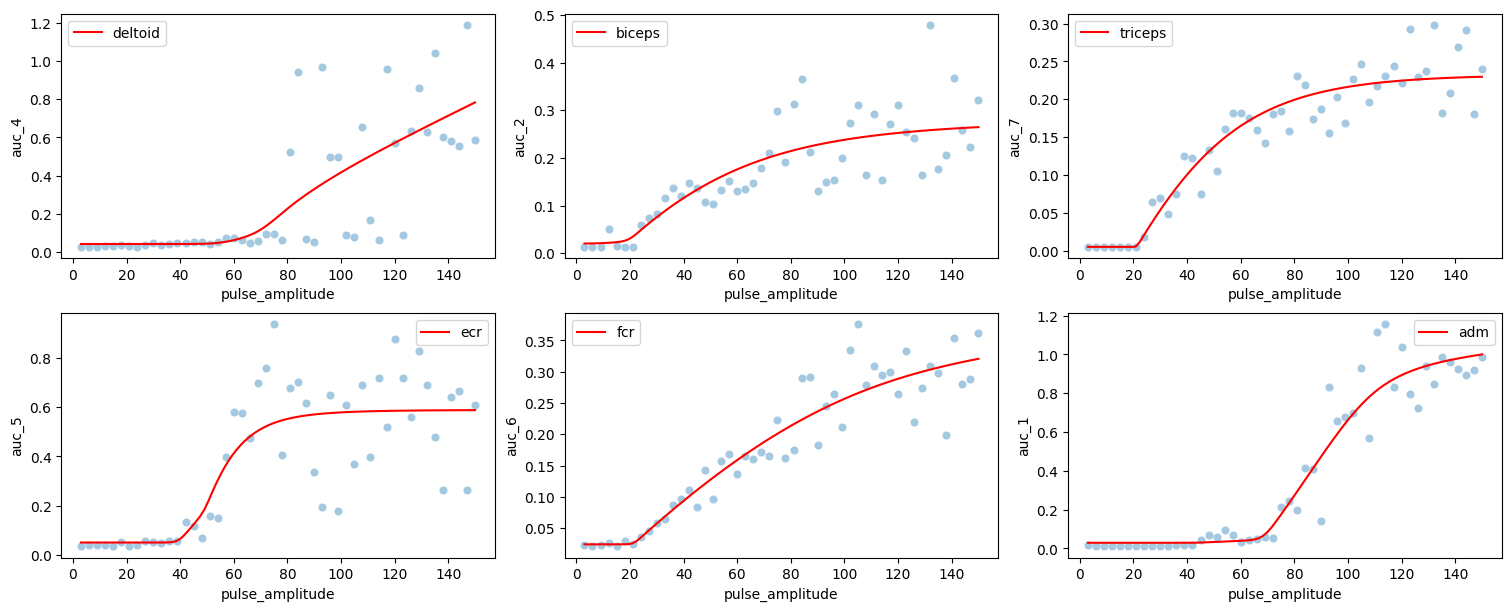

In [63]:
c_ind = 4
c = combinations[c_ind]

ind = df[model.combination_columns].apply(tuple, axis=1).isin([c])
temp_df = df[ind].reset_index(drop=True).copy()

colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_muscles)))

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), constrained_layout=True)

for i in range(n_muscles):
    muscle_ind = i
    muscle = muscles[muscle_ind]
    ax = axes[i // ncols, i % ncols]
    sns.scatterplot(x=temp_df[model.intensity], y=temp_df[muscles_map[muscle]] / y_max[0, 0, c_ind, muscle_ind], ax=ax, alpha=.4)
    sns.lineplot(x=x[:, 0, c_ind, 0], y=y_map[:, c_ind, muscle_ind] / y_max[0, 0, c_ind, muscle_ind], ax=ax, color="r", label=f"{muscle}")

In [64]:
entropy_adj.shape

(100, 9000, 403)

In [65]:
def _process_selectivity(keep_conditions: list, threshold: int):
    pr = []
    mask = []
    heat_map = []

    for i, (i_pos, i_size) in enumerate(keep_conditions):
        curr_pr = []
        curr_mask = []
        curr_heat_map = []

        for j, (j_pos, j_size) in enumerate(keep_conditions):
            if i == j:
                curr_pr.append(0)
                curr_mask.append(False)
                curr_heat_map.append("D")
                continue

            i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos and c[2] == i_size]
            j_com = [(j, c) for j, c in enumerate(combinations) if c[1] == j_pos and c[2] == j_size]

            i_com = sorted(i_com, key=lambda x: x[1][0])
            j_com = sorted(j_com, key=lambda x: x[1][0])

            i_sub = set([v[1][0] for v in i_com])
            j_sub = set([v[1][0] for v in j_com])
            common_sub = i_sub.intersection(j_sub)

            i_ind = [v[0] for v in i_com if v[1][0] in common_sub]
            j_ind = [v[0] for v in j_com if v[1][0] in common_sub]

            if not len(common_sub) or len(common_sub) < threshold:
                curr_pr.append(0)
                curr_mask.append(False)
                curr_heat_map.append(f"NA:{len(common_sub)}")
                continue

            curr_mask.append(True)

            ## Distributions
            i_entropy = entropy_adj[..., i_ind]
            i_entropy = i_entropy.mean(axis=-1)
            i_amp_ind = np.argmax(i_entropy.mean(axis=-1))
            i_entropy = i_entropy[i_amp_ind, :]

            j_entropy = entropy_adj[..., j_ind]
            j_entropy = j_entropy.mean(axis=-1)
            j_amp_ind = np.argmax(j_entropy.mean(axis=-1))
            j_entropy = j_entropy[j_amp_ind, :]

            # diff should be > 0 for i to be more selective than j
            diff_entropy = i_entropy - j_entropy
            pr_entropy = (diff_entropy > 0).mean()
            curr_pr.append(pr_entropy)
            curr_heat_map.append(f"{pr_entropy:.2f}:{len(common_sub)}")

        pr.append(curr_pr)
        mask.append(curr_mask)
        heat_map.append(curr_heat_map)

    pr = np.array(pr)
    mask = np.array(mask)
    heat_map = np.array(heat_map)

    return pr, mask, heat_map

### Non-ground contacts

#### Q. How far lateral? - Small

In [66]:
keep_conditions_inv = [c for c in conditions_inv if c[1] == "S" and c[0].split("-")[0] != "" and c[0].split("-")[0][:2] == c[0].split("-")[1][:2] and c[0].split("-")[0][2:] == "M" and c[0].split("-")[1][2:] in {"LL", "L", "LM1", "LM2"}]

keep_conditions_inv

[('C5M-C5L', 'S'),
 ('C5M-C5LL', 'S'),
 ('C5M-C5LM1', 'S'),
 ('C5M-C5LM2', 'S'),
 ('C6M-C6L', 'S'),
 ('C6M-C6LL', 'S'),
 ('C6M-C6LM1', 'S'),
 ('C6M-C6LM2', 'S')]

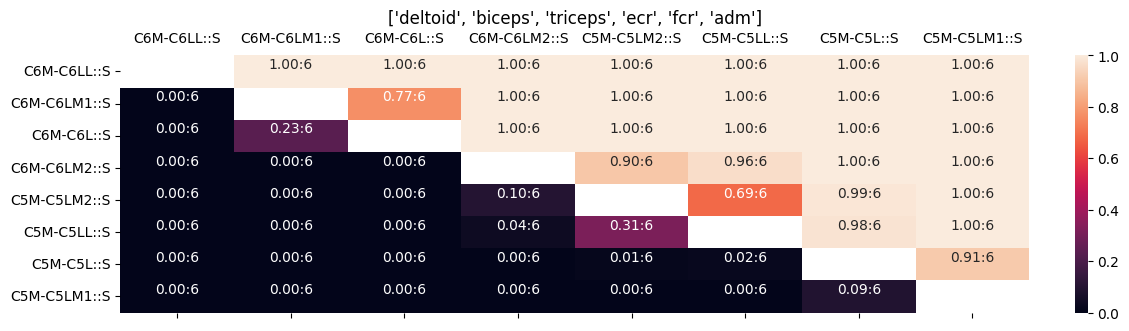

In [67]:
keep_conditions = [
    (
        encoder_dict[model.features[0]].transform(np.array([c_inv[0]]))[0],
        encoder_dict[model.features[1]].transform(np.array([c_inv[1]]))[0]
    ) for c_inv in keep_conditions_inv
]
n_keep_conditions = len(keep_conditions)
keep_conditions_inv_joined = ["::".join(row) for row in keep_conditions_inv]
keep_muscles = muscles

pr, mask, heat_map = _process_selectivity(keep_conditions=keep_conditions, threshold=1)

plt.figure(figsize=(1.4 * n_keep_conditions, .4 * n_keep_conditions), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_conditions_inv_joined)[ind],
    yticklabels=np.array(keep_conditions_inv_joined)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title(f"{keep_muscles}");

In [68]:
selectivity_score = {
    "non_ground_small_lateral": {},
    "non_ground_big_lateral": {},
    "non_ground_small_vs_big": {},
    "ground_small_lateral": {},
    "ground_big_lateral": {},
    "ground_small_vs_big": {}
}

for i, c_inv in enumerate(np.array(keep_conditions_inv_joined)[ind].tolist()):
    selectivity_score["non_ground_small_lateral"][c_inv] = [n_keep_conditions - i]

for i, (i_pos, i_size) in enumerate(keep_conditions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos and c[2] == i_size]
    # can further filter i_com to include only applicable combinations
    i_ind = [v[0] for v in i_com]

    i_entropy = entropy_adj[..., i_ind]
    i_entropy = i_entropy.mean(axis=-1)

    i_amp_ind = np.argmax(i_entropy.mean(axis=-1))

    i_entropy = i_entropy[i_amp_ind, :]

    c_inv_joined = keep_conditions_inv_joined[i]
    selectivity_score["non_ground_small_lateral"][c_inv_joined].append(i_entropy.mean())

In [69]:
selectivity_score["non_ground_small_lateral"]

{'C6M-C6LL::S': [8, 0.3822296971529564],
 'C6M-C6LM1::S': [7, 0.35517240185615184],
 'C6M-C6L::S': [6, 0.34939566079438084],
 'C6M-C6LM2::S': [5, 0.2786362036754234],
 'C5M-C5LM2::S': [4, 0.2600891211555291],
 'C5M-C5LL::S': [3, 0.25389044462129257],
 'C5M-C5L::S': [2, 0.22946258106494785],
 'C5M-C5LM1::S': [1, 0.2131919761332325]}

#### Q. How far lateral? - Big

In [70]:
keep_conditions_inv = [c for c in conditions_inv if c[1] == "B" and c[0].split("-")[0] != "" and c[0].split("-")[0][:2] == c[0].split("-")[1][:2] and c[0].split("-")[0][2:] == "M" and c[0].split("-")[1][2:] in {"LL", "L", "LM"}]

keep_conditions_inv

[('C5M-C5L', 'B'),
 ('C5M-C5LL', 'B'),
 ('C5M-C5LM', 'B'),
 ('C6M-C6L', 'B'),
 ('C6M-C6LL', 'B'),
 ('C6M-C6LM', 'B')]

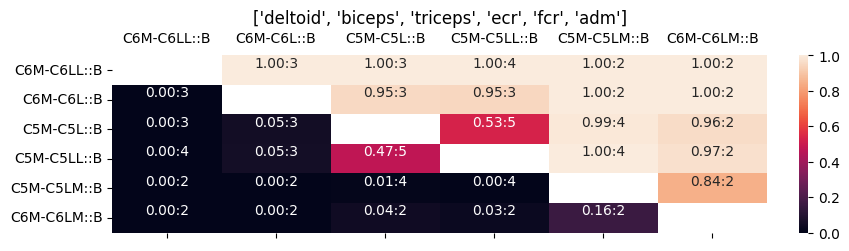

In [72]:
keep_conditions = [
    (
        encoder_dict[model.features[0]].transform(np.array([c_inv[0]]))[0],
        encoder_dict[model.features[1]].transform(np.array([c_inv[1]]))[0]
    ) for c_inv in keep_conditions_inv
]
n_keep_conditions = len(keep_conditions)
keep_conditions_inv_joined = ["::".join(row) for row in keep_conditions_inv]
keep_muscles = muscles

pr, mask, heat_map = _process_selectivity(keep_conditions=keep_conditions, threshold=1)

plt.figure(figsize=(1.4 * n_keep_conditions, .4 * n_keep_conditions), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_conditions_inv_joined)[ind],
    yticklabels=np.array(keep_conditions_inv_joined)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title(f"{keep_muscles}");

In [74]:
for i, c_inv in enumerate(np.array(keep_conditions_inv_joined)[ind].tolist()):
    selectivity_score["non_ground_big_lateral"][c_inv] = [n_keep_conditions - i]

for i, (i_pos, i_size) in enumerate(keep_conditions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos and c[2] == i_size]
    # can further filter i_com to include only applicable combinations
    i_ind = [v[0] for v in i_com]

    i_entropy = entropy_adj[..., i_ind]
    i_entropy = i_entropy.mean(axis=-1)

    i_amp_ind = np.argmax(i_entropy.mean(axis=-1))

    i_entropy = i_entropy[i_amp_ind, :]

    c_inv_joined = keep_conditions_inv_joined[i]
    selectivity_score["non_ground_big_lateral"][c_inv_joined].append(i_entropy.mean())

In [75]:
selectivity_score["non_ground_big_lateral"]

{'C6M-C6LL::B': [6, 0.3286142708627223],
 'C6M-C6L::B': [5, 0.27754772880036466],
 'C5M-C5L::B': [4, 0.1829669035415737],
 'C5M-C5LL::B': [3, 0.18336687739637292],
 'C5M-C5LM::B': [2, 0.16101965469716342],
 'C6M-C6LM::B': [1, 0.2375817716017231]}

#### Q. Small vs Big?

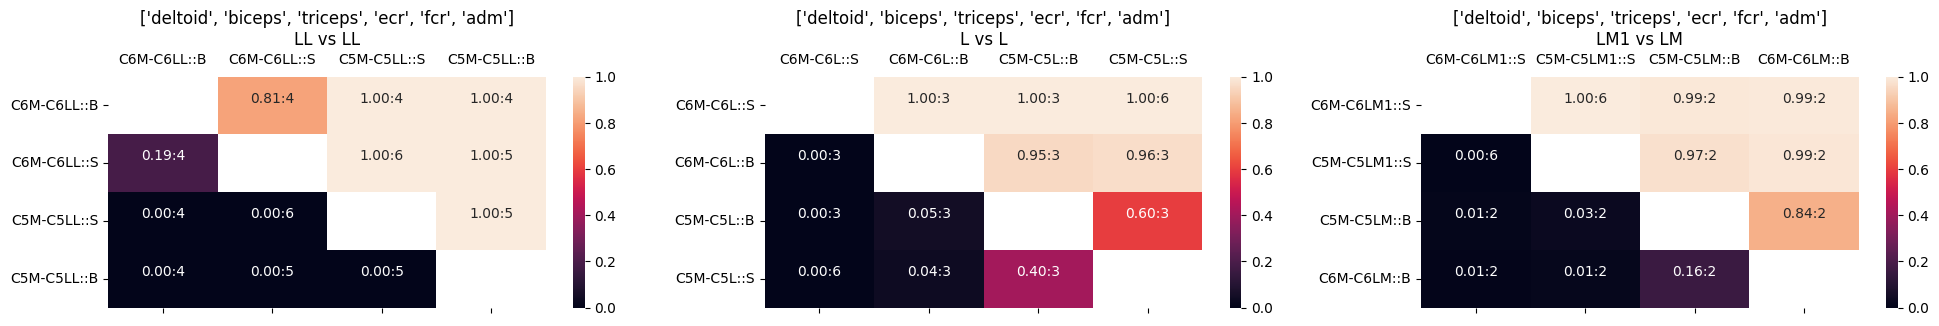

In [76]:
small_big_lateral_pattern = [
    ("LL", "LL"), ("L", "L"), ("LM1", "LM")
]

nrows, ncols = 1, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 3 * nrows))

for i, (small_laterality, big_laterality) in enumerate(small_big_lateral_pattern):
    ax = axes[i % ncols]

    keep_conditions_inv = [c for c in conditions_inv if c[1] == "S" and c[0].split("-")[0] != "" and c[0].split("-")[0][:2] == c[0].split("-")[1][:2] and c[0].split("-")[0][2:] == "M" and c[0].split("-")[1][2:] in [small_laterality]]
    keep_conditions_inv += [c for c in conditions_inv if c[1] == "B" and c[0].split("-")[0] != "" and c[0].split("-")[0][:2] == c[0].split("-")[1][:2] and c[0].split("-")[0][2:] == "M" and c[0].split("-")[1][2:] in [big_laterality]]

    keep_conditions = [
        (
            encoder_dict[model.features[0]].transform(np.array([c_inv[0]]))[0],
            encoder_dict[model.features[1]].transform(np.array([c_inv[1]]))[0]
        ) for c_inv in keep_conditions_inv
    ]
    n_keep_conditions = len(keep_conditions)
    keep_conditions_inv_joined = ["::".join(row) for row in keep_conditions_inv]
    keep_muscles = muscles

    pr, mask, heat_map = _process_selectivity(keep_conditions=keep_conditions, threshold=1)

    ind = list(zip(
        range(pr.shape[0]),
        (pr > .95).sum(axis=1) / mask.sum(axis=1),
        pr.sum(axis=1).tolist() / mask.sum(axis=1)
    ))

    ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
    ind = [v[0] for v in ind]

    sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind], ax=ax)
    sns.heatmap(
        pr[ind, :][:, ind],
        annot=heat_map[ind, :][:, ind],
        annot_kws={'va':'bottom'},
        fmt="",
        cbar=False,
        xticklabels=np.array(keep_conditions_inv_joined)[ind],
        yticklabels=np.array(keep_conditions_inv_joined)[ind],
        mask=~mask[ind, :][:, ind],
        ax=ax
    )

    ax.tick_params(labeltop=True, labelbottom=False)
    ax.set_xticklabels(np.array(keep_conditions_inv_joined)[ind], rotation=0)
    ax.set_yticklabels(np.array(keep_conditions_inv_joined)[ind], rotation=0)
    ax.set_title(f"{keep_muscles}\n{small_laterality} vs {big_laterality}");

    selectivity_score["non_ground_small_vs_big"][f"{small_laterality}_{big_laterality}"] = {}

    for i, c_inv in enumerate(np.array(keep_conditions_inv_joined)[ind].tolist()):
        selectivity_score["non_ground_small_vs_big"][f"{small_laterality}_{big_laterality}"][c_inv] = [n_keep_conditions - i]

    for i, (i_pos, i_size) in enumerate(keep_conditions):
        i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos and c[2] == i_size]
        # can further filter i_com to include only applicable combinations
        i_ind = [v[0] for v in i_com]

        i_entropy = entropy_adj[..., i_ind]
        i_entropy = i_entropy.mean(axis=-1)

        i_amp_ind = np.argmax(i_entropy.mean(axis=-1))

        i_entropy = i_entropy[i_amp_ind, :]

        c_inv_joined = keep_conditions_inv_joined[i]
        selectivity_score["non_ground_small_vs_big"][f"{small_laterality}_{big_laterality}"][c_inv_joined].append(i_entropy.mean())


In [77]:
selectivity_score["non_ground_small_vs_big"]["LL_LL"]

{'C6M-C6LL::B': [4, 0.3286142708627223],
 'C6M-C6LL::S': [3, 0.3822296971529564],
 'C5M-C5LL::S': [2, 0.25389044462129257],
 'C5M-C5LL::B': [1, 0.18336687739637292]}

In [78]:
selectivity_score["non_ground_small_vs_big"]["L_L"]

{'C6M-C6L::S': [4, 0.34939566079438084],
 'C6M-C6L::B': [3, 0.27754772880036466],
 'C5M-C5L::B': [2, 0.1829669035415737],
 'C5M-C5L::S': [1, 0.22946258106494785]}

In [79]:
selectivity_score["non_ground_small_vs_big"]["LM1_LM"]

{'C6M-C6LM1::S': [4, 0.35517240185615184],
 'C5M-C5LM1::S': [3, 0.2131919761332325],
 'C5M-C5LM::B': [2, 0.16101965469716342],
 'C6M-C6LM::B': [1, 0.2375817716017231]}

### Ground

#### Q. How far lateral? - Small

In [82]:
keep_conditions_inv = [c for c in conditions_inv if c[1] == "S" and c[0].split("-")[0] == ""]
keep_conditions_inv

[('-C5L', 'S'),
 ('-C5LL', 'S'),
 ('-C5LM1', 'S'),
 ('-C5LM2', 'S'),
 ('-C5M', 'S'),
 ('-C6L', 'S'),
 ('-C6LL', 'S'),
 ('-C6LM1', 'S'),
 ('-C6LM2', 'S'),
 ('-C6M', 'S')]

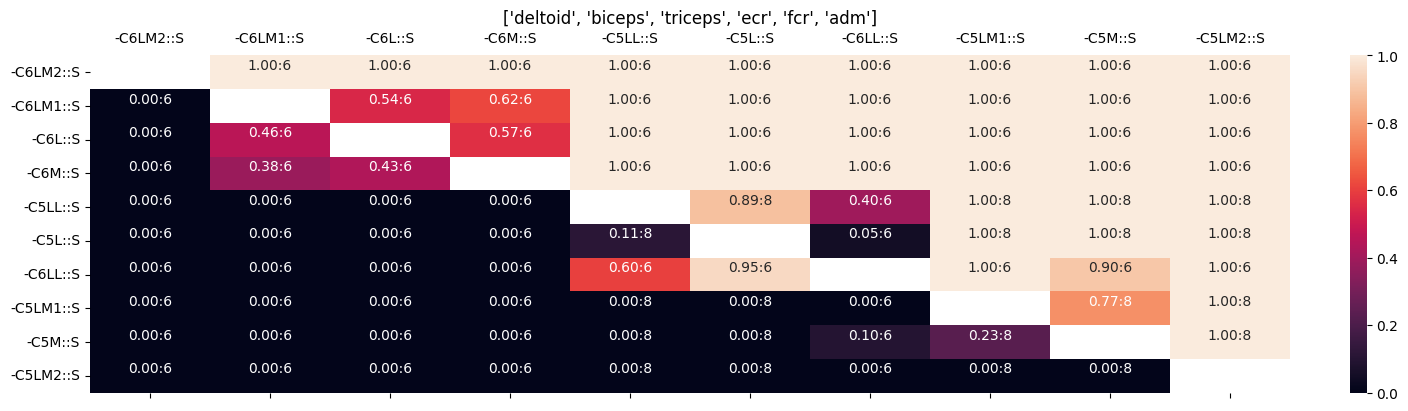

In [83]:
keep_conditions = [
    (
        encoder_dict[model.features[0]].transform(np.array([c_inv[0]]))[0],
        encoder_dict[model.features[1]].transform(np.array([c_inv[1]]))[0]
    ) for c_inv in keep_conditions_inv
]
n_keep_conditions = len(keep_conditions)
keep_conditions_inv_joined = ["::".join(row) for row in keep_conditions_inv]
keep_muscles = muscles

pr, mask, heat_map = _process_selectivity(keep_conditions=keep_conditions, threshold=1)

plt.figure(figsize=(1.4 * n_keep_conditions, .4 * n_keep_conditions), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_conditions_inv_joined)[ind],
    yticklabels=np.array(keep_conditions_inv_joined)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title(f"{keep_muscles}");

In [85]:
for i, c_inv in enumerate(np.array(keep_conditions_inv_joined)[ind].tolist()):
    selectivity_score["ground_small_lateral"][c_inv] = [n_keep_conditions - i]

for i, (i_pos, i_size) in enumerate(keep_conditions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos and c[2] == i_size]
    # can further filter i_com to include only applicable combinations
    i_ind = [v[0] for v in i_com]

    i_entropy = entropy_adj[..., i_ind]
    i_entropy = i_entropy.mean(axis=-1)

    i_amp_ind = np.argmax(i_entropy.mean(axis=-1))

    i_entropy = i_entropy[i_amp_ind, :]

    c_inv_joined = keep_conditions_inv_joined[i]
    selectivity_score["ground_small_lateral"][c_inv_joined].append(i_entropy.mean())

In [86]:
selectivity_score["ground_small_lateral"]

{'-C6LM2::S': [10, 0.4652503286670153],
 '-C6LM1::S': [9, 0.4252836547398016],
 '-C6L::S': [8, 0.4240584402851851],
 '-C6M::S': [7, 0.4216797231961268],
 '-C5LL::S': [6, 0.2396794975286788],
 '-C5L::S': [5, 0.22634538826303768],
 '-C6LL::S': [4, 0.2514111504842751],
 '-C5LM1::S': [3, 0.19898067737614877],
 '-C5M::S': [2, 0.19093030325536636],
 '-C5LM2::S': [1, 0.15869420960720187]}

#### Q. How far lateral? - Big

In [87]:
lateral_pattern = ["LL", "L", "LM", "M"]
keep_conditions_inv = [c for c in conditions_inv if c[1] == "B" and c[0].split("-")[0] == "" and c[0].split("-")[1][2:] in lateral_pattern]
keep_conditions_inv

[('-C5L', 'B'),
 ('-C5LL', 'B'),
 ('-C5LM', 'B'),
 ('-C5M', 'B'),
 ('-C6L', 'B'),
 ('-C6LL', 'B'),
 ('-C6LM', 'B'),
 ('-C6M', 'B'),
 ('-C7LM', 'B'),
 ('-C7M', 'B')]

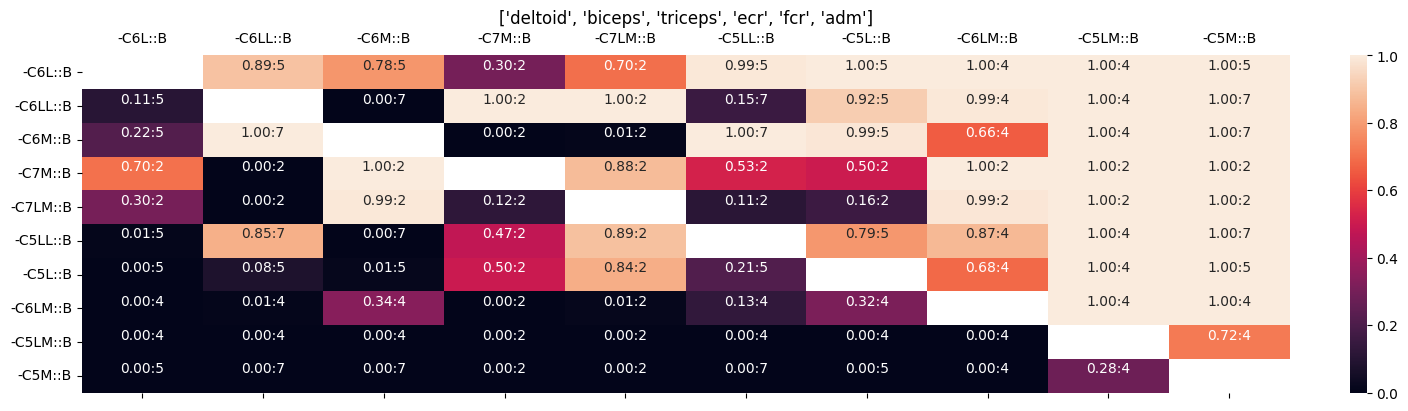

In [88]:
keep_conditions = [
    (
        encoder_dict[model.features[0]].transform(np.array([c_inv[0]]))[0],
        encoder_dict[model.features[1]].transform(np.array([c_inv[1]]))[0]
    ) for c_inv in keep_conditions_inv
]
n_keep_conditions = len(keep_conditions)
keep_conditions_inv_joined = ["::".join(row) for row in keep_conditions_inv]
keep_muscles = muscles

pr, mask, heat_map = _process_selectivity(keep_conditions=keep_conditions, threshold=1)

plt.figure(figsize=(1.4 * n_keep_conditions, .4 * n_keep_conditions), constrained_layout=True)

ind = list(zip(
    range(pr.shape[0]),
    (pr > .95).sum(axis=1) / mask.sum(axis=1),
    pr.sum(axis=1).tolist() / mask.sum(axis=1)
))

ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
ind = [v[0] for v in ind]

sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind])
sns.heatmap(
    pr[ind, :][:, ind],
    annot=heat_map[ind, :][:, ind],
    annot_kws={'va':'bottom'},
    fmt="",
    cbar=False,
    xticklabels=np.array(keep_conditions_inv_joined)[ind],
    yticklabels=np.array(keep_conditions_inv_joined)[ind],
    mask=~mask[ind, :][:, ind]
)

plt.tick_params(labeltop=True, labelbottom=False)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title(f"{keep_muscles}");

In [89]:
for i, c_inv in enumerate(np.array(keep_conditions_inv_joined)[ind].tolist()):
    selectivity_score["ground_big_lateral"][c_inv] = [n_keep_conditions - i]

for i, (i_pos, i_size) in enumerate(keep_conditions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos and c[2] == i_size]
    # can further filter i_com to include only applicable combinations
    i_ind = [v[0] for v in i_com]

    i_entropy = entropy_adj[..., i_ind]
    i_entropy = i_entropy.mean(axis=-1)

    i_amp_ind = np.argmax(i_entropy.mean(axis=-1))

    i_entropy = i_entropy[i_amp_ind, :]

    c_inv_joined = keep_conditions_inv_joined[i]
    selectivity_score["ground_big_lateral"][c_inv_joined].append(i_entropy.mean())

In [91]:
selectivity_score["ground_big_lateral"]

{'-C6L::B': [10, 0.24905579822395682],
 '-C6LL::B': [9, 0.2231526176781904],
 '-C6M::B': [8, 0.26668721759624564],
 '-C7M::B': [7, 0.1704843415370581],
 '-C7LM::B': [6, 0.15328120414195848],
 '-C5LL::B': [5, 0.23540634583765416],
 '-C5L::B': [4, 0.21195937298933198],
 '-C6LM::B': [3, 0.21106050317706196],
 '-C5LM::B': [2, 0.1747565678728127],
 '-C5M::B': [1, 0.1560204272713662]}

#### Q. Small vs Big?

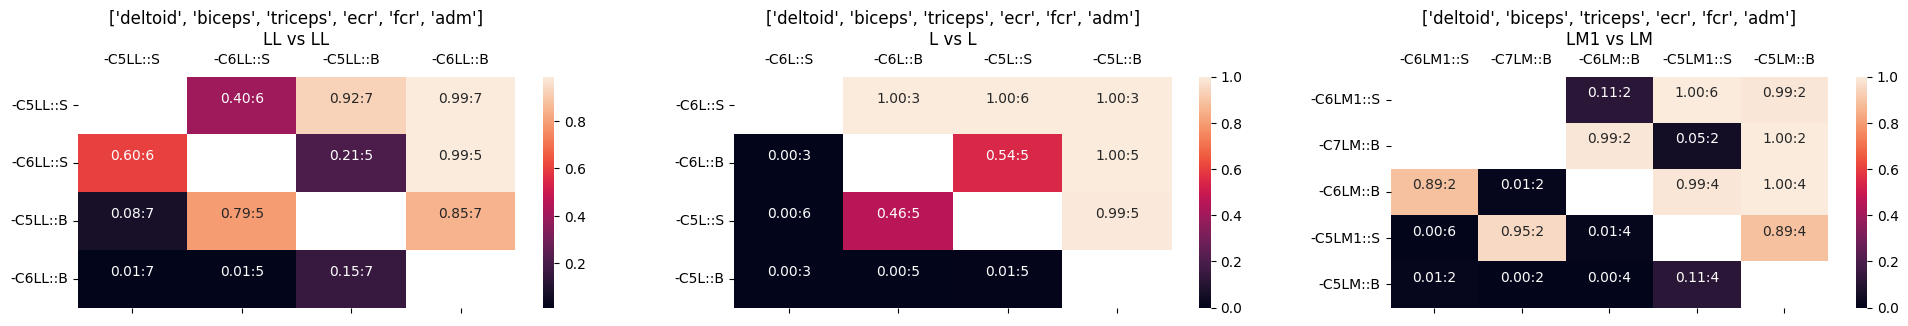

In [92]:
small_big_lateral_pattern = [
    ("LL", "LL"), ("L", "L"), ("LM1", "LM")
]

nrows, ncols = 1, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 3 * nrows))

for i, (small_laterality, big_laterality) in enumerate(small_big_lateral_pattern):
    ax = axes[i % ncols]

    keep_conditions_inv = [c for c in conditions_inv if c[1] == "S" and c[0].split("-")[0] == "" and c[0].split("-")[1][2:] in [small_laterality]]
    keep_conditions_inv += [c for c in conditions_inv if c[1] == "B" and c[0].split("-")[0] == "" and c[0].split("-")[1][2:] in [big_laterality]]

    keep_conditions = [
        (
            encoder_dict[model.features[0]].transform(np.array([c_inv[0]]))[0],
            encoder_dict[model.features[1]].transform(np.array([c_inv[1]]))[0]
        ) for c_inv in keep_conditions_inv
    ]
    n_keep_conditions = len(keep_conditions)
    keep_conditions_inv_joined = ["::".join(row) for row in keep_conditions_inv]
    keep_muscles = muscles

    pr, mask, heat_map = _process_selectivity(keep_conditions=keep_conditions, threshold=1)

    ind = list(zip(
        range(pr.shape[0]),
        (pr > .95).sum(axis=1) / mask.sum(axis=1),
        pr.sum(axis=1).tolist() / mask.sum(axis=1)
    ))

    ind = sorted(ind, key=lambda x: (-x[1], -x[2], x[0]))
    ind = [v[0] for v in ind]

    sns.heatmap(pr[ind, :][:, ind], annot=False, mask=~mask[ind, :][:, ind], ax=ax)
    sns.heatmap(
        pr[ind, :][:, ind],
        annot=heat_map[ind, :][:, ind],
        annot_kws={'va':'bottom'},
        fmt="",
        cbar=False,
        xticklabels=np.array(keep_conditions_inv_joined)[ind],
        yticklabels=np.array(keep_conditions_inv_joined)[ind],
        mask=~mask[ind, :][:, ind],
        ax=ax
    )

    ax.tick_params(labeltop=True, labelbottom=False)
    ax.set_xticklabels(np.array(keep_conditions_inv_joined)[ind], rotation=0)
    ax.set_yticklabels(np.array(keep_conditions_inv_joined)[ind], rotation=0)
    ax.set_title(f"{keep_muscles}\n{small_laterality} vs {big_laterality}");

    selectivity_score["ground_small_vs_big"][f"{small_laterality}_{big_laterality}"] = {}

    for i, c_inv in enumerate(np.array(keep_conditions_inv_joined)[ind].tolist()):
        selectivity_score["ground_small_vs_big"][f"{small_laterality}_{big_laterality}"][c_inv] = [n_keep_conditions - i]

    for i, (i_pos, i_size) in enumerate(keep_conditions):
        i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos and c[2] == i_size]
        # can further filter i_com to include only applicable combinations
        i_ind = [v[0] for v in i_com]

        i_entropy = entropy_adj[..., i_ind]
        i_entropy = i_entropy.mean(axis=-1)

        i_amp_ind = np.argmax(i_entropy.mean(axis=-1))

        i_entropy = i_entropy[i_amp_ind, :]

        c_inv_joined = keep_conditions_inv_joined[i]
        selectivity_score["ground_small_vs_big"][f"{small_laterality}_{big_laterality}"][c_inv_joined].append(i_entropy.mean())


In [93]:
selectivity_score["ground_small_vs_big"]["LL_LL"]

{'-C5LL::S': [4, 0.2396794975286788],
 '-C6LL::S': [3, 0.2514111504842751],
 '-C5LL::B': [2, 0.23540634583765416],
 '-C6LL::B': [1, 0.2231526176781904]}

In [94]:
selectivity_score["ground_small_vs_big"]["L_L"]

{'-C6L::S': [4, 0.4240584402851851],
 '-C6L::B': [3, 0.24905579822395682],
 '-C5L::S': [2, 0.22634538826303768],
 '-C5L::B': [1, 0.21195937298933198]}

In [95]:
selectivity_score["ground_small_vs_big"]["LM1_LM"]

{'-C6LM1::S': [5, 0.4252836547398016],
 '-C7LM::B': [4, 0.15328120414195848],
 '-C6LM::B': [3, 0.21106050317706196],
 '-C5LM1::S': [2, 0.19898067737614877],
 '-C5LM::B': [1, 0.1747565678728127]}

## Selectivity vs Efficacy

In [96]:
selectivity_score.keys()

dict_keys(['non_ground_small_lateral', 'non_ground_big_lateral', 'non_ground_small_vs_big', 'ground_small_lateral', 'ground_big_lateral', 'ground_small_vs_big'])

In [97]:
selectivity_score["non_ground_small_lateral"]

{'C6M-C6LL::S': [8, 0.3822296971529564],
 'C6M-C6LM1::S': [7, 0.35517240185615184],
 'C6M-C6L::S': [6, 0.34939566079438084],
 'C6M-C6LM2::S': [5, 0.2786362036754234],
 'C5M-C5LM2::S': [4, 0.2600891211555291],
 'C5M-C5LL::S': [3, 0.25389044462129257],
 'C5M-C5L::S': [2, 0.22946258106494785],
 'C5M-C5LM1::S': [1, 0.2131919761332325]}

In [98]:
efficacy_score["non_ground_small_lateral"]

{'C6M-C6L::S': [8, 150.4131023609686],
 'C6M-C6LM2::S': [7, 152.72150876024878],
 'C6M-C6LM1::S': [6, 164.263842269927],
 'C6M-C6LL::S': [5, 174.5925200560202],
 'C5M-C5LM2::S': [4, 255.65923407811877],
 'C5M-C5L::S': [3, 258.7922221672641],
 'C5M-C5LM1::S': [2, 283.81870010108486],
 'C5M-C5LL::S': [1, 354.2028387866565]}

Text(0.5, 0.98, 'non_ground_small_lateral: Non ground - How far lateral? - Small')

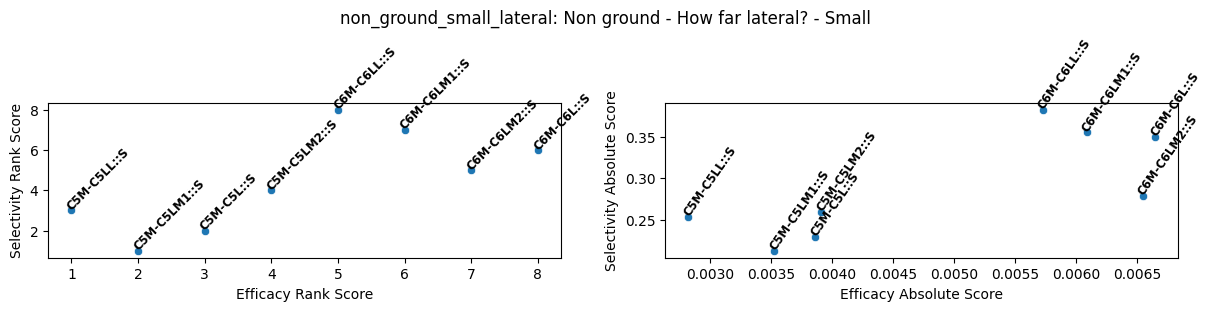

In [107]:
key = "non_ground_small_lateral"

efficacy_conditions = [c for c, v in efficacy_score[key].items()]
selectivity_conditions = [c for c, v in selectivity_score[key].items()]

assert sorted(efficacy_conditions) == sorted(selectivity_conditions)
curr_conditions = sorted(efficacy_conditions)

efficacy_rank_score = [efficacy_score[key][c][0] for c in curr_conditions]
selectivity_rank_score = [selectivity_score[key][c][0] for c in curr_conditions]

efficacy_absolute_score = [(1 / efficacy_score[key][c][1]) for c in curr_conditions]
selectivity_absolute_score = [selectivity_score[key][c][1].item() for c in curr_conditions]

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 3 * nrows), constrained_layout=True)

ax = axes[0]
x = efficacy_rank_score
y = selectivity_rank_score
sns.scatterplot(x=x, y=y, ax=ax)
for i in range(len(curr_conditions)):
    ax.text(
        x[i]+0.001,
        y[i]+0.005,
        curr_conditions[i],
        horizontalalignment='left',
        size='small',
        color='black',
        weight='semibold',
        rotation=45,
        wrap=True
    )
ax.set_xlabel("Efficacy Rank Score")
ax.set_ylabel("Selectivity Rank Score")

ax = axes[1]
x = efficacy_absolute_score
y = selectivity_absolute_score
sns.scatterplot(x=x, y=y, ax=ax)
for i in range(len(curr_conditions)):
    ax.text(
        x[i]+0.00001,
        y[i]+0.0005,
        curr_conditions[i],
        horizontalalignment='left',
        size='small',
        color='black',
        weight='semibold',
        rotation=55,
        wrap=True
    )
ax.set_xlabel("Efficacy Absolute Score")
ax.set_ylabel("Selectivity Absolute Score")
fig.suptitle(f"{key}: Non ground - How far lateral? - Small")

Text(0.5, 0.98, 'non_ground_big_lateral: Non ground - How far lateral? - Big')

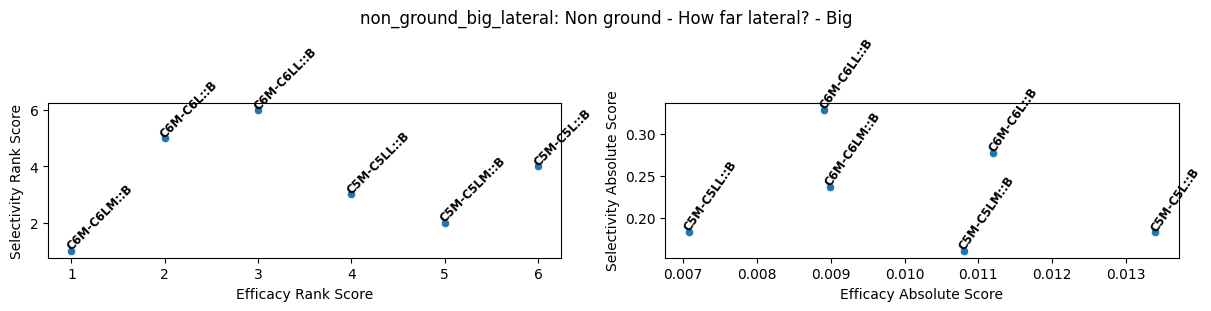

In [108]:
key = "non_ground_big_lateral"

efficacy_conditions = [c for c, v in efficacy_score[key].items()]
selectivity_conditions = [c for c, v in selectivity_score[key].items()]

assert sorted(efficacy_conditions) == sorted(selectivity_conditions)
curr_conditions = sorted(efficacy_conditions)

efficacy_rank_score = [efficacy_score[key][c][0] for c in curr_conditions]
selectivity_rank_score = [selectivity_score[key][c][0] for c in curr_conditions]

efficacy_absolute_score = [(1 / efficacy_score[key][c][1]) for c in curr_conditions]
selectivity_absolute_score = [selectivity_score[key][c][1].item() for c in curr_conditions]

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 3 * nrows), constrained_layout=True)

ax = axes[0]
x = efficacy_rank_score
y = selectivity_rank_score
sns.scatterplot(x=x, y=y, ax=ax)
for i in range(len(curr_conditions)):
    ax.text(
        x[i]+0.001,
        y[i]+0.005,
        curr_conditions[i],
        horizontalalignment='left',
        size='small',
        color='black',
        weight='semibold',
        rotation=45,
        wrap=True
    )
ax.set_xlabel("Efficacy Rank Score")
ax.set_ylabel("Selectivity Rank Score")

ax = axes[1]
x = efficacy_absolute_score
y = selectivity_absolute_score
sns.scatterplot(x=x, y=y, ax=ax)
for i in range(len(curr_conditions)):
    ax.text(
        x[i]+0.00001,
        y[i]+0.0005,
        curr_conditions[i],
        horizontalalignment='left',
        size='small',
        color='black',
        weight='semibold',
        rotation=55,
        wrap=True
    )
ax.set_xlabel("Efficacy Absolute Score")
ax.set_ylabel("Selectivity Absolute Score")
fig.suptitle(f"{key}: Non ground - How far lateral? - Big")

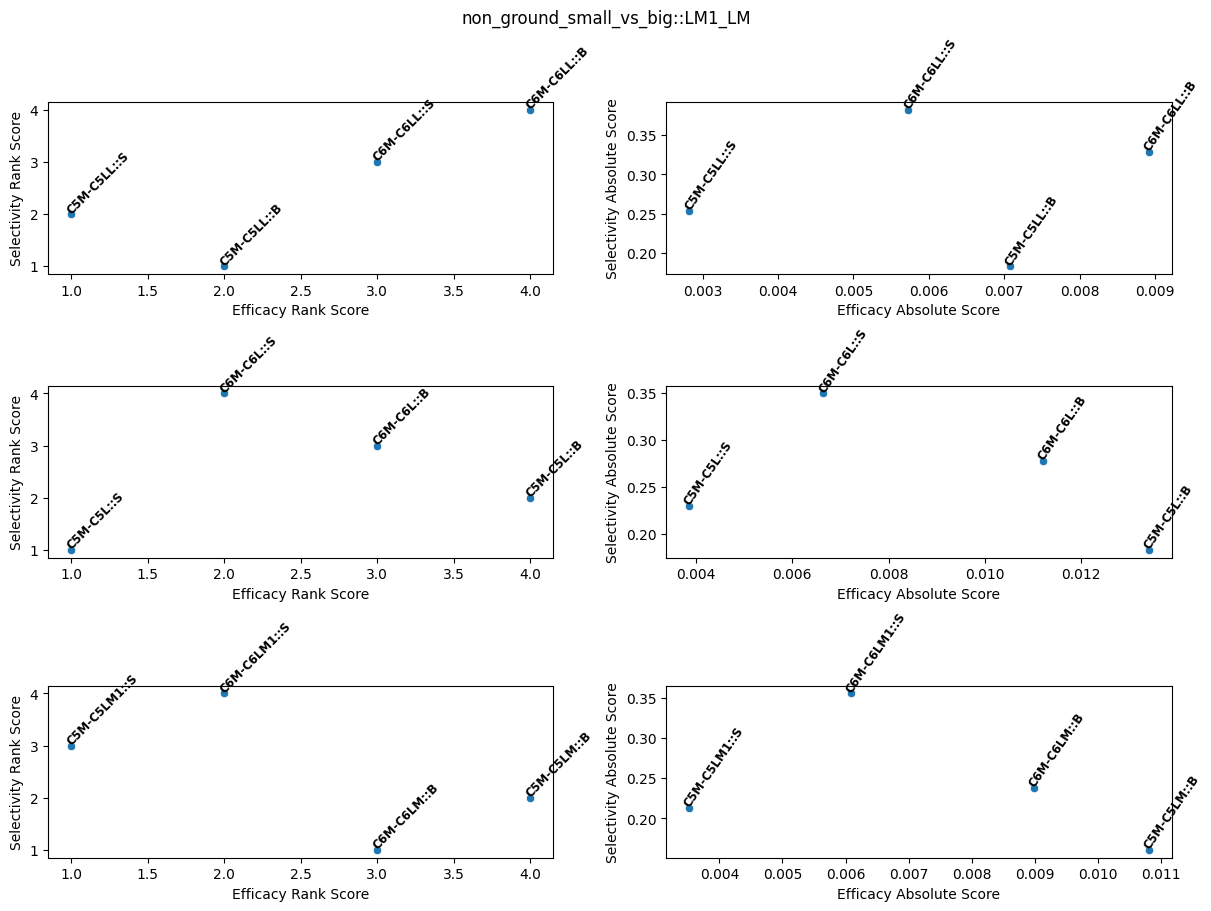

In [143]:



key = "non_ground_small_vs_big"
key2s = ["LL_LL", "L_L", "LM1_LM"]

nrows, ncols = len(key2s), 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 3 * nrows), constrained_layout=True)

for j, key2 in enumerate(key2s):
    efficacy_conditions = [c for c, v in efficacy_score[key][key2].items()]
    selectivity_conditions = [c for c, v in selectivity_score[key][key2].items()]

    assert sorted(efficacy_conditions) == sorted(selectivity_conditions)
    curr_conditions = sorted(efficacy_conditions)

    efficacy_rank_score = [efficacy_score[key][key2][c][0] for c in curr_conditions]
    selectivity_rank_score = [selectivity_score[key][key2][c][0] for c in curr_conditions]

    efficacy_absolute_score = [(1 / efficacy_score[key][key2][c][1]) for c in curr_conditions]
    selectivity_absolute_score = [selectivity_score[key][key2][c][1].item() for c in curr_conditions]

    ax = axes[j, 0]
    x = efficacy_rank_score
    y = selectivity_rank_score
    sns.scatterplot(x=x, y=y, ax=ax)
    for i in range(len(curr_conditions)):
        ax.text(
            x[i]+0.001,
            y[i]+0.005,
            curr_conditions[i],
            horizontalalignment='left',
            size='small',
            color='black',
            weight='semibold',
            rotation=45,
            wrap=True
        )
    ax.set_xlabel("Efficacy Rank Score")
    ax.set_ylabel("Selectivity Rank Score")

    ax = axes[j, 1]
    x = efficacy_absolute_score
    y = selectivity_absolute_score
    sns.scatterplot(x=x, y=y, ax=ax)
    for i in range(len(curr_conditions)):
        ax.text(
            x[i]+0.00001,
            y[i]+0.0005,
            curr_conditions[i],
            horizontalalignment='left',
            size='small',
            color='black',
            weight='semibold',
            rotation=55,
            wrap=True
        )
    ax.set_xlabel("Efficacy Absolute Score")
    ax.set_ylabel("Selectivity Absolute Score")
    fig.suptitle(f"{key}::{key2}")

Text(0.5, 0.98, 'ground_small_lateral: Ground - How far lateral? - Small')

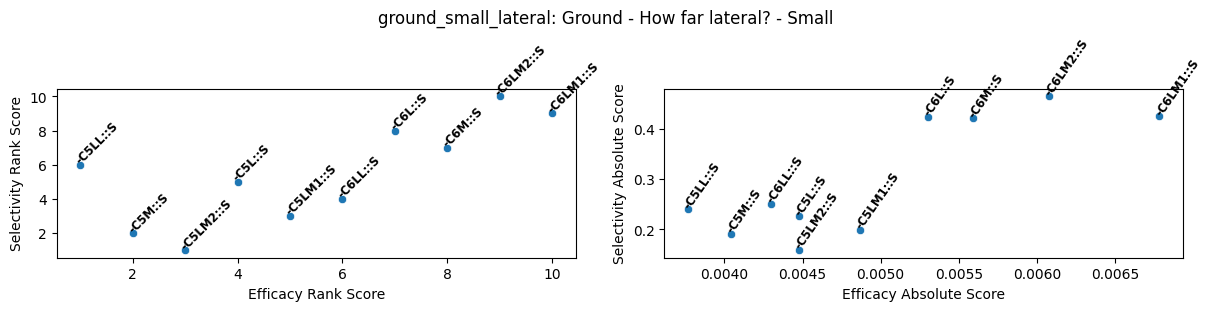

In [110]:
key = "ground_small_lateral"

efficacy_conditions = [c for c, v in efficacy_score[key].items()]
selectivity_conditions = [c for c, v in selectivity_score[key].items()]

assert sorted(efficacy_conditions) == sorted(selectivity_conditions)
curr_conditions = sorted(efficacy_conditions)

efficacy_rank_score = [efficacy_score[key][c][0] for c in curr_conditions]
selectivity_rank_score = [selectivity_score[key][c][0] for c in curr_conditions]

efficacy_absolute_score = [(1 / efficacy_score[key][c][1]) for c in curr_conditions]
selectivity_absolute_score = [selectivity_score[key][c][1].item() for c in curr_conditions]

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 3 * nrows), constrained_layout=True)

ax = axes[0]
x = efficacy_rank_score
y = selectivity_rank_score
sns.scatterplot(x=x, y=y, ax=ax)
for i in range(len(curr_conditions)):
    ax.text(
        x[i]+0.001,
        y[i]+0.005,
        curr_conditions[i],
        horizontalalignment='left',
        size='small',
        color='black',
        weight='semibold',
        rotation=45,
        wrap=True
    )
ax.set_xlabel("Efficacy Rank Score")
ax.set_ylabel("Selectivity Rank Score")

ax = axes[1]
x = efficacy_absolute_score
y = selectivity_absolute_score
sns.scatterplot(x=x, y=y, ax=ax)
for i in range(len(curr_conditions)):
    ax.text(
        x[i]+0.00001,
        y[i]+0.0005,
        curr_conditions[i],
        horizontalalignment='left',
        size='small',
        color='black',
        weight='semibold',
        rotation=55,
        wrap=True
    )
ax.set_xlabel("Efficacy Absolute Score")
ax.set_ylabel("Selectivity Absolute Score")
fig.suptitle(f"{key}: Ground - How far lateral? - Small")

Text(0.5, 0.98, 'ground_big_lateral: Ground - How far lateral? - Big')

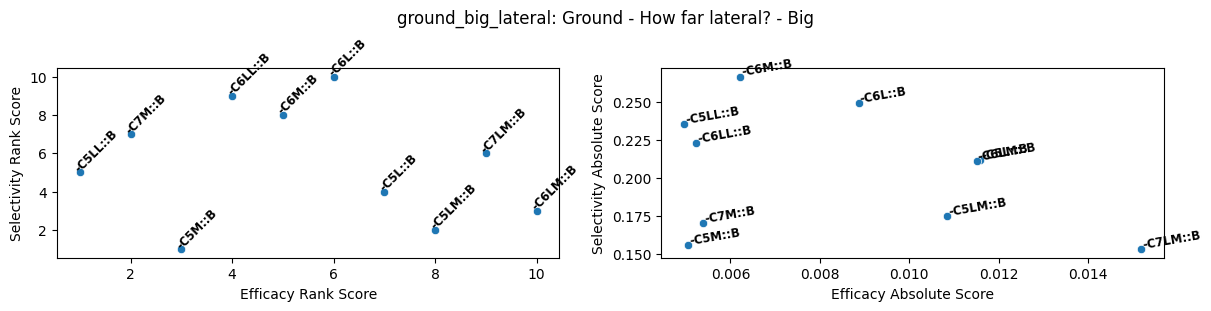

In [131]:
key = "ground_big_lateral"

efficacy_conditions = [c for c, v in efficacy_score[key].items()]
selectivity_conditions = [c for c, v in selectivity_score[key].items()]

assert sorted(efficacy_conditions) == sorted(selectivity_conditions)
curr_conditions = sorted(efficacy_conditions)

efficacy_rank_score = [efficacy_score[key][c][0] for c in curr_conditions]
selectivity_rank_score = [selectivity_score[key][c][0] for c in curr_conditions]

efficacy_absolute_score = [(1 / efficacy_score[key][c][1]) for c in curr_conditions]
selectivity_absolute_score = [selectivity_score[key][c][1].item() for c in curr_conditions]

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 3 * nrows), constrained_layout=True)

ax = axes[0]
x = efficacy_rank_score
y = selectivity_rank_score
sns.scatterplot(x=x, y=y, ax=ax)
for i in range(len(curr_conditions)):
    ax.text(
        x[i]+0.001,
        y[i]+0.005,
        curr_conditions[i],
        horizontalalignment='left',
        size='small',
        color='black',
        weight='semibold',
        rotation=45,
        wrap=True
    )
ax.set_xlabel("Efficacy Rank Score")
ax.set_ylabel("Selectivity Rank Score")

ax = axes[1]
x = efficacy_absolute_score
y = selectivity_absolute_score
sns.scatterplot(x=x, y=y, ax=ax)
for i in range(len(curr_conditions)):
    ax.text(
        x[i]+0.00005,
        y[i]+0.0005,
        curr_conditions[i],
        horizontalalignment='left',
        size='small',
        color='black',
        weight='semibold',
        rotation=10,
        wrap=True
    )
ax.set_xlabel("Efficacy Absolute Score")
ax.set_ylabel("Selectivity Absolute Score")
fig.suptitle(f"{key}: Ground - How far lateral? - Big")

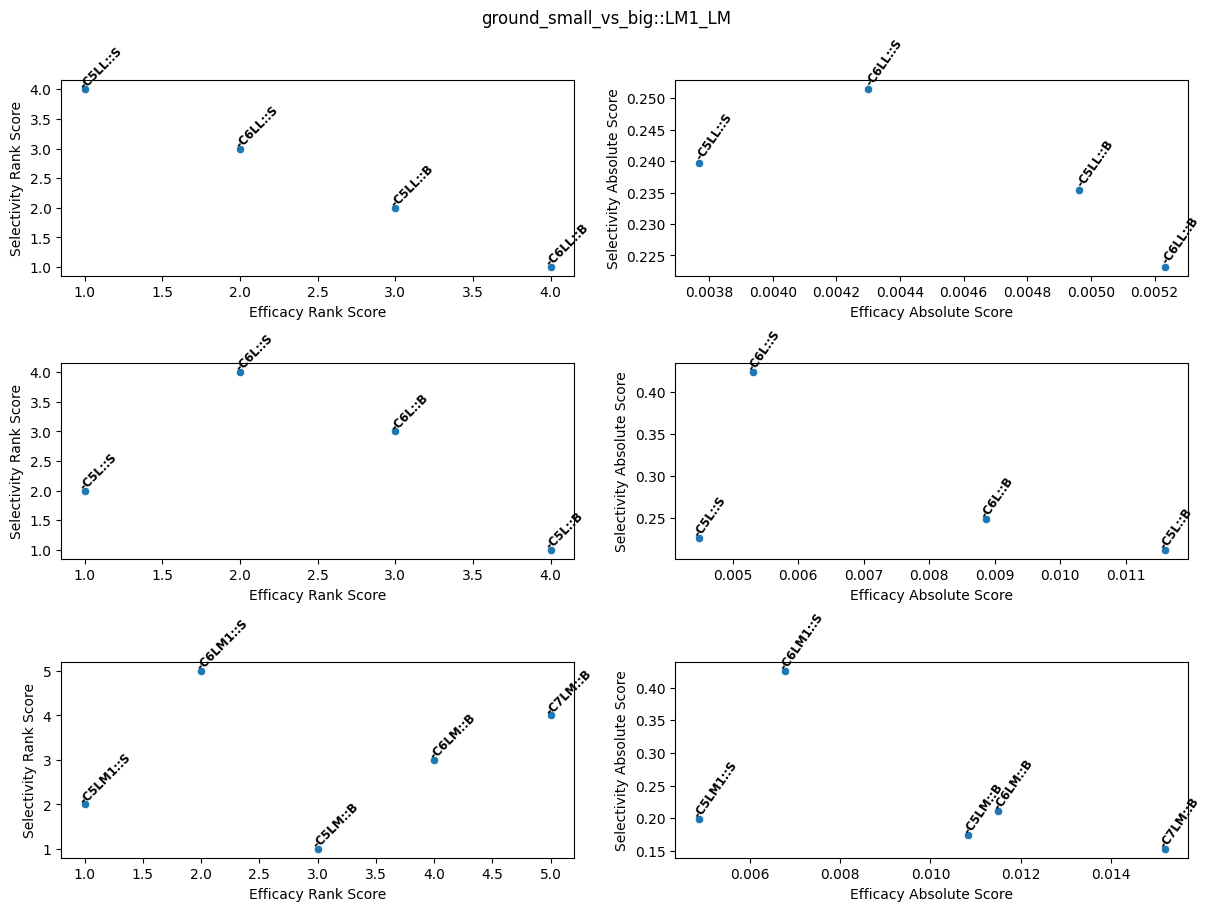

In [142]:
key = "ground_small_vs_big"
key2s = ["LL_LL", "L_L", "LM1_LM"]

nrows, ncols = len(key2s), 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 3 * nrows), constrained_layout=True)

for j, key2 in enumerate(key2s):
    efficacy_conditions = [c for c, v in efficacy_score[key][key2].items()]
    selectivity_conditions = [c for c, v in selectivity_score[key][key2].items()]

    assert sorted(efficacy_conditions) == sorted(selectivity_conditions)
    curr_conditions = sorted(efficacy_conditions)

    efficacy_rank_score = [efficacy_score[key][key2][c][0] for c in curr_conditions]
    selectivity_rank_score = [selectivity_score[key][key2][c][0] for c in curr_conditions]

    efficacy_absolute_score = [(1 / efficacy_score[key][key2][c][1]) for c in curr_conditions]
    selectivity_absolute_score = [selectivity_score[key][key2][c][1].item() for c in curr_conditions]

    ax = axes[j, 0]
    x = efficacy_rank_score
    y = selectivity_rank_score
    sns.scatterplot(x=x, y=y, ax=ax)
    for i in range(len(curr_conditions)):
        ax.text(
            x[i]+0.001,
            y[i]+0.005,
            curr_conditions[i],
            horizontalalignment='left',
            size='small',
            color='black',
            weight='semibold',
            rotation=45,
            wrap=True
        )
    ax.set_xlabel("Efficacy Rank Score")
    ax.set_ylabel("Selectivity Rank Score")

    ax = axes[j, 1]
    x = efficacy_absolute_score
    y = selectivity_absolute_score
    sns.scatterplot(x=x, y=y, ax=ax)
    for i in range(len(curr_conditions)):
        ax.text(
            x[i]+0.00001,
            y[i]+0.0005,
            curr_conditions[i],
            horizontalalignment='left',
            size='small',
            color='black',
            weight='semibold',
            rotation=55,
            wrap=True
        )
    ax.set_xlabel("Efficacy Absolute Score")
    ax.set_ylabel("Selectivity Absolute Score")
    fig.suptitle(f"{key}::{key2}")

In [164]:
entropy_adj.shape

(100, 6000, 403)

In [176]:
x = []

for i, (i_pos, i_size) in enumerate(conditions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos and c[2] == i_size]
    # can further filter i_com to include only applicable combinations
    i_ind = [v[0] for v in i_com]
    i_a = a[:, i_ind, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)
    x.append(i_a.mean())

x = np.array(x)

In [ ]:
y = []

for i, (i_pos, i_size) in enumerate(conditions):
    i_com = [(i, c) for i, c in enumerate(combinations) if c[1] == i_pos and c[2] == i_size]
    # can further filter i_com to include only applicable combinations
    i_ind = [v[0] for v in i_com]
    i_a = a[:, i_ind, ...]
    i_a = i_a.reshape(i_a.shape[0], -1)
    x.append(i_a.mean())
